In [ ]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [ ]:
a

In [448]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/mouse_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [977]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='10kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['10kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

    jac_sim = hm.hiCMatrix(exp_file_path)




    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    #df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))
    
    #df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[7])

In [988]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='10kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['10kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/hic_gene_inter_KR.h5'

    jac_sim = hm.hiCMatrix(exp_file_path)




    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    df_max_gene = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    #df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))
    

In [1106]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='10kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['10kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/hic_gene_gw_KR_KR.h5'

    jac_sim = hm.hiCMatrix(exp_file_path)




    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    df_max_gene_whole = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    #df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))

In [1340]:
all_bins = [x[1] if x[3].decode() == "non-gene" else x[3].decode() for x in jac_sim.cut_intervals]

In [1341]:
df_max_gene_whole_by_bins = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_bins)

In [1355]:
df_max_gene_whole_by_bins

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            0.000000         9547.720703   
ENSMUSG00000064842         9547.720703            0.000000   
ENSMUSG00000051951         2216.954346         2727.325439   
ENSMUSG00000102851         1906.376831         2293.062500   
ENSMUSG00000103377         1178.407837         1286.997803   
...                                ...                 ...   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693         2216.954346         1906.376831   
ENSMUSG00000064842         2727.325439         2293.062500   
ENSMUSG00000051951        30276.083984        20926.302734   
ENSMUSG00000102851        20926.302734            0.000000   
ENSMUSG00000103377        21260.355469         2312.511475   
...                                ...                 ...   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693         1178.407837         1304.377563   
ENSMUSG00000064842         1286.997803         1435.507812   
ENSMUSG00000051951        21260.355469        25657.593750   
ENSMUSG00000102851         2312.511475         2398.909180   
ENSMUSG00000103377            0.000000        20676.308594   
...                                ...                 ...   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693         1200.575073         1200.575073   
ENSMUSG00000064842         1103.201660         1103.201660   
ENSMUSG00000051951        19046.398438        30276.083984   
ENSMUSG00000102851         1663.662231         1663.662231   
ENSMUSG00000103377         2527.110596         2527.110596   
...                                ...                 ...   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   
non-gene                      0.000000            0.000000   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  246275  \
ENSMUSG00000102693          900.577026          919.432373  ...     0.0   
ENSMUSG00000064842          915.848450          903.993164  ...     0.0   
ENSMUSG00000051951        30276.083984        19521.736328  ...     0.0   
ENSMUSG00000102851         1273.023926         1314.934937  ...     0.0   
ENSMUSG00000103377         1877.537720         1872.084473  ...     0.0   
...                                ...                 ...  ...     ...   
non-gene                      0.000000            0.000000  ...     0.0   
non-gene                      0.000000            0.000000  ...     0.0   
non-gene                      0.000000            0.000000  ...     0.0   
non-gene                      0.000000            0.000000  ...     0.0   
non-gene                      0.000000            0.000000  ...     0.0   

                    246276  246277  246278  246279  246280  246281  246282  \
ENSMUSG00000102693     0.0     0.0     0.0     0.0     0.0   

In [1353]:
df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins[df_max_gene_whole_by_bins.columns.isin(all_genes)]



In [1370]:
each_bin_sum = df_max_gene_whole_group_1.sum(axis=0)

<AxesSubplot:ylabel='Count'>

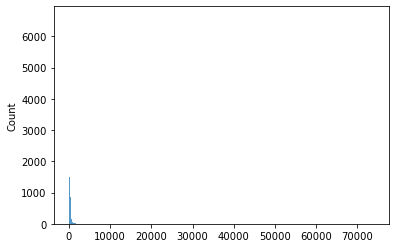

In [1371]:
sns.histplot(each_bin_sum)

In [1356]:
df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(gaba_100)]

In [1357]:
df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[~df_max_gene_whole_by_bins_coding.index.isin(gaba_100)]

In [1358]:
df_max_gene_whole_group_2

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            0.000000         9547.720703   
ENSMUSG00000064842         9547.720703            0.000000   
ENSMUSG00000051951         2216.954346         2727.325439   
ENSMUSG00000102851         1906.376831         2293.062500   
ENSMUSG00000103377         1178.407837         1286.997803   
...                                ...                 ...   
ENSMUSG00000070263            0.588563            0.369096   
ENSMUSG00000094649            0.000000            0.323475   
ENSMUSG00000069475            0.612805            1.921488   
ENSMUSG00000059326            1.338004            0.839079   
ENSMUSG00000095993            0.593173            0.000000   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693         2216.954346         1906.376831   
ENSMUSG00000064842         2727.325439         2293.062500   
ENSMUSG00000051951        30276.083984        20926.302734   
ENSMUSG00000102851        20926.302734            0.000000   
ENSMUSG00000103377        21260.355469         2312.511475   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            0.000000   
ENSMUSG00000094649            1.546415            0.884328   
ENSMUSG00000069475            2.322864            0.000000   
ENSMUSG00000059326            1.493021            0.382318   
ENSMUSG00000095993            1.605401            0.338983   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693         1178.407837         1304.377563   
ENSMUSG00000064842         1286.997803         1435.507812   
ENSMUSG00000051951        21260.355469        25657.593750   
ENSMUSG00000102851         2312.511475         2398.909180   
ENSMUSG00000103377            0.000000        20676.308594   
...                                ...                 ...   
ENSMUSG00000070263            2.657797            0.713917   
ENSMUSG00000094649            0.517620            0.938514   
ENSMUSG00000069475            1.229895            0.000000   
ENSMUSG00000059326            1.174848            0.608615   
ENSMUSG00000095993            0.595247            0.359754   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693         1200.575073         1200.575073   
ENSMUSG00000064842         1103.201660         1103.201660   
ENSMUSG00000051951        19046.398438        30276.083984   
ENSMUSG00000102851         1663.662231         1663.662231   
ENSMUSG00000103377         2527.110596         2527.110596   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            2.960253   
ENSMUSG00000094649            0.778309            1.460061   
ENSMUSG00000069475            0.000000            1.729088   
ENSMUSG00000059326            0.504725            0.755062   
ENSMUSG00000095993            0.298344            1.605401   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  246275  \
ENSMUSG00000102693          900.577026          919.432373  ...     0.0   
ENSMUSG00000064842          915.848450          903.993164  ...     0.0   
ENSMUSG00000051951        30276.083984        19521.736328  ...     0.0   
ENSMUSG00000102851         1273.023926         1314.934937  ...     0.0   
ENSMUSG00000103377         1877.537720         1872.084473  ...     0.0   
...                                ...                 ...  ...     ...   
ENSMUSG00000070263            0.000000            0.000000  ...     0.0   
ENSMUSG00000094649            0.000000            0.586324  ...     0.0   
ENSMUSG00000069475            0.829267            0.000000  ...     0.0   
ENSMUSG00000059326            0.226329            0.190112  ...     0.0   
ENSMUSG00000095993            1.605401            1.011382  ...     0.0   

                    246276  246277  246278  246279  246280  246281  246282  \
ENSMUSG00000102693     0.0     0.0     0.0     0.0     0.0   

In [1360]:
df_max_gene_whole_group_1['ENSMUSG00000102693']

ENSMUSG00000062209    36.521908
ENSMUSG00000033007     4.632099
ENSMUSG00000036766    26.181456
ENSMUSG00000049866     4.637427
ENSMUSG00000040710    14.326316
                        ...    
ENSMUSG00000033278     2.911005
ENSMUSG00000096988     0.671550
ENSMUSG00000055471     2.612112
ENSMUSG00000024990     0.437853
ENSMUSG00000025207     0.436807
Name: ENSMUSG00000102693, Length: 96, dtype: float32

In [1365]:
df_max_gene_whole_group_1[246275].sum()

0.0

In [1345]:
df_max_gene_whole_group_2 = df_max_gene_whole_group_2[~df_max_gene_whole_group_2.index.isin(['non-gene'])]

In [1346]:
df_max_gene_whole_group_2

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            0.000000         9547.720703   
ENSMUSG00000064842         9547.720703            0.000000   
ENSMUSG00000051951         2216.954346         2727.325439   
ENSMUSG00000102851         1906.376831         2293.062500   
ENSMUSG00000103377         1178.407837         1286.997803   
...                                ...                 ...   
ENSMUSG00000070263            0.588563            0.369096   
ENSMUSG00000094649            0.000000            0.323475   
ENSMUSG00000069475            0.612805            1.921488   
ENSMUSG00000059326            1.338004            0.839079   
ENSMUSG00000095993            0.593173            0.000000   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693         2216.954346         1906.376831   
ENSMUSG00000064842         2727.325439         2293.062500   
ENSMUSG00000051951        30276.083984        20926.302734   
ENSMUSG00000102851        20926.302734            0.000000   
ENSMUSG00000103377        21260.355469         2312.511475   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            0.000000   
ENSMUSG00000094649            1.546415            0.884328   
ENSMUSG00000069475            2.322864            0.000000   
ENSMUSG00000059326            1.493021            0.382318   
ENSMUSG00000095993            1.605401            0.338983   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693         1178.407837         1304.377563   
ENSMUSG00000064842         1286.997803         1435.507812   
ENSMUSG00000051951        21260.355469        25657.593750   
ENSMUSG00000102851         2312.511475         2398.909180   
ENSMUSG00000103377            0.000000        20676.308594   
...                                ...                 ...   
ENSMUSG00000070263            2.657797            0.713917   
ENSMUSG00000094649            0.517620            0.938514   
ENSMUSG00000069475            1.229895            0.000000   
ENSMUSG00000059326            1.174848            0.608615   
ENSMUSG00000095993            0.595247            0.359754   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693         1200.575073         1200.575073   
ENSMUSG00000064842         1103.201660         1103.201660   
ENSMUSG00000051951        19046.398438        30276.083984   
ENSMUSG00000102851         1663.662231         1663.662231   
ENSMUSG00000103377         2527.110596         2527.110596   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            2.960253   
ENSMUSG00000094649            0.778309            1.460061   
ENSMUSG00000069475            0.000000            1.729088   
ENSMUSG00000059326            0.504725            0.755062   
ENSMUSG00000095993            0.298344            1.605401   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  246275  \
ENSMUSG00000102693          900.577026          919.432373  ...     0.0   
ENSMUSG00000064842          915.848450          903.993164  ...     0.0   
ENSMUSG00000051951        30276.083984        19521.736328  ...     0.0   
ENSMUSG00000102851         1273.023926         1314.934937  ...     0.0   
ENSMUSG00000103377         1877.537720         1872.084473  ...     0.0   
...                                ...                 ...  ...     ...   
ENSMUSG00000070263            0.000000            0.000000  ...     0.0   
ENSMUSG00000094649            0.000000            0.586324  ...     0.0   
ENSMUSG00000069475            0.829267            0.000000  ...     0.0   
ENSMUSG00000059326            0.226329            0.190112  ...     0.0   
ENSMUSG00000095993            1.605401            1.011382  ...     0.0   

                    246276  246277  246278  246279  246280  246281  246282  \
ENSMUSG00000102693     0.0     0.0     0.0     0.0     0.0   

In [1296]:
df_max_gene_whole_by_bins

307          310           320           325     \
ENSMUSG00000102693     0.000000  9547.720703   2216.954346   1906.376831   
ENSMUSG00000064842  9547.720703     0.000000   2727.325439   2293.062500   
ENSMUSG00000051951  2216.954346  2727.325439  30276.083984  20926.302734   
ENSMUSG00000102851  1906.376831  2293.062500  20926.302734      0.000000   
ENSMUSG00000103377  1178.407837  1286.997803  21260.355469   2312.511475   
...                         ...          ...           ...           ...   
non-gene               0.000000     0.000000      0.000000      0.000000   
non-gene               0.000000     0.000000      0.000000      0.000000   
non-gene               0.000000     0.000000      0.000000      0.000000   
non-gene               0.000000     0.000000      0.000000      0.000000   
non-gene               0.000000     0.000000      0.000000      0.000000   

                          336           337           346           346     \
ENSMUSG00000102693   1178.407837   1304.377563   1200.575073   1200.575073   
ENSMUSG00000064842   1286.997803   1435.507812   1103.201660   1103.201660   
ENSMUSG00000051951  21260.355469  25657.593750  19046.398438  30276.083984   
ENSMUSG00000102851   2312.511475   2398.909180   1663.662231   1663.662231   
ENSMUSG00000103377      0.000000  20676.308594   2527.110596   2527.110596   
...                          ...           ...           ...           ...   
non-gene                0.000000      0.000000      0.000000      0.000000   
non-gene                0.000000      0.000000      0.000000      0.000000   
non-gene                0.000000      0.000000      0.000000      0.000000   
non-gene                0.000000      0.000000      0.000000      0.000000   
non-gene                0.000000      0.000000      0.000000      0.000000   

                          351           353     ...  246275  246276  246277  \
ENSMUSG00000102693    900.577026    919.432373  ...     0.0     0.0     0.0   
ENSMUSG00000064842    915.848450    903.993164  ...     0.0     0.0     0.0   
ENSMUSG00000051951  30276.083984  19521.736328  ...     0.0     0.0     0.0   
ENSMUSG00000102851   1273.023926   1314.934937  ...     0.0     0.0     0.0   
ENSMUSG00000103377   1877.537720   1872.084473  ...     0.0     0.0     0.0   
...                          ...           ...  ...     ...     ...     ...   
non-gene                0.000000      0.000000  ...     0.0     0.0     0.0   
non-gene                0.000000      0.000000  ...     0.0     0.0     0.0   
non-gene                0.000000      0.000000  ...     0.0     0.0     0.0   
non-gene                0.000000      0.000000  ...     0.0     0.0     0.0   
non-gene                0.000000      0.000000  ...     0.0     0.0     0.0   

                    246278  246279  246280  246281  246282  246283  246284  
ENSMUSG00000102693     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
ENSMUSG00000064842     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
ENSMUSG00000051951     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
ENSMUSG00000102851     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
ENSMUSG00000103377     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...                    ...     ...     ...     ...     ...     ...     ...  
non-gene               0.0     0.0     0.0     0.0     0.0     0.0     0.0  
non-gene               0.0     0.0     0.0     0.0     0.0     0.0     0.0  
non-gene               0.0     0.0     0.0     0.0     0.0     0.0     0.0  
non-gene               0.0     0.0     0.0     0.0     0.0     0.0     0.0  
non-gene               0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[156467 rows x 156467 columns]

In [1435]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')
marker_list['gene'] = marker_list['gene'].str.upper()
#marker_list = marker_list[marker_list['rank'] < 250] 

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [1436]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')
df_optimal_marker = df_optimal_marker[df_optimal_marker['n_genes'] >= 10]
df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] <= 0.8]
#df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] >= 0.8]
df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmax()]
#df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmin()]



In [1437]:
marker_list_optimal_marker = []
for marker, n_genes in zip(df_optimal_marker['marker_set'].tolist(), df_optimal_marker['n_genes'].tolist()):
    #print (n_genes)
    
    marker_list_optimal_marker.append(marker_list[(marker_list['cell_type'] == marker) & (marker_list['rank'] <= n_genes)])
    

In [1438]:
marker_list = pd.concat(marker_list_optimal_marker)

In [1439]:
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 


In [1313]:
marker_list

group     cell_type  rank    gene  recurrence     auroc  fold_change  \
0     all     GABAergic     1    GAD1           7  0.941159   116.960472   
1     all     GABAergic     2    GAD2           7  0.928440   139.811415   
2     all     GABAergic     3   ERBB4           7  0.921449    81.717383   
3     all     GABAergic     4  KCNIP1           7  0.916919    32.252038   
4     all     GABAergic     5   RBMS3           7  0.902093    17.038869   
..    ...           ...   ...     ...         ...       ...          ...   
294   all  Non-Neuronal    96     MAG           6  0.648512   165.820081   
295   all  Non-Neuronal    97   FNBP1           6  0.648028     5.592886   
296   all  Non-Neuronal    98  FRMD4B           6  0.647805     9.050547   
297   all  Non-Neuronal    99    PLLP           6  0.645540    61.884548   
298   all  Non-Neuronal   100   PRR5L           6  0.645414   187.906185   

     fold_change_detection   expression  precision  ...  population_size  \
0                 9.289078   820.463486   0.659089  ...     10207.000000   
1                13.987046   659.151566   0.730005  ...     10207.000000   
2                 5.736415  2257.167753   0.514809  ...     10207.000000   
3                10.796420   588.571993   0.687830  ...     10207.000000   
4                 3.607831   340.701798   0.442861  ...     10207.000000   
..                     ...          ...        ...  ...              ...   
294              16.747920   456.955370   0.370001  ...      8908.857143   
295               0.955553   454.931925   0.063414  ...      8908.857143   
296               2.335387   192.151003   0.124702  ...      8908.857143   
297              12.642643   190.039132   0.314672  ...      8908.857143   
298              30.603359   334.996404   0.447383  ...      8908.857143   

     n_datasets   scSS  snSS  scCv2  snCv2  snCv3M  scCv3  snCv3Z  \
0             7   True  True   True   True    True   True    True   
1             7   True  True   True   True    True   True    True   
2             7   True  True   True   True    True   True    True   
3             7   True  True   True   True    True   True    True   
4             7   True  True   True   True    True   True    True   
..          ...    ...   ...    ...    ...     ...    ...     ...   
294           7  False  True   True   True    True   True    True   
295           7  False  True   True   True    True   True    True   
296           7  False  True   True   True    True   True    True   
297           7  False  True   True   True    True   True    True   
298           7  False  True   True   True    True   True    True   

                gene_id  
0    ENSMUSG00000070880  
1    ENSMUSG00000026787  
2    ENSMUSG00000062209  
3    ENSMUSG00000053519  
4    ENSMUSG00000039607  
..                  ...  
294  ENSMUSG00000036634  
295  ENSMUSG00000075415  
296  ENSMUSG00000030064  
297  ENSMUSG00000031775  
298  ENSMUSG00000032841  

[299 rows x 21 columns]

In [1440]:
marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

In [1441]:
marker_table.fillna(0, inplace=True)

In [1442]:
marker_table[marker_table != 0] = 1

In [1398]:
gaba_100= marker_table[marker_table['GABAergic'] == 1].index.tolist()

In [1319]:
from scipy.stats import mannwhitneyu

In [1320]:
males = [19, 22, 16, 29, 24]
females = [20, 11, 17, 12]

In [1375]:
df_max_gene_whole_group_1[0]

ENSMUSG00000062209    0.0
ENSMUSG00000033007    0.0
ENSMUSG00000036766    0.0
ENSMUSG00000049866    0.0
ENSMUSG00000040710    0.0
                     ... 
ENSMUSG00000033278    0.0
ENSMUSG00000096988    0.0
ENSMUSG00000055471    0.0
ENSMUSG00000024990    0.0
ENSMUSG00000025207    0.0
Name: 0, Length: 96, dtype: float32

In [1372]:
U, p = mannwhitneyu(df_max_gene_whole_group_1['ENSMUSG00000102693'].tolist(), df_max_gene_whole_group_2['ENSMUSG00000102693'].tolist(), alternative="greater")

In [1422]:
df_max_gene_whole_group_2.iloc[:, 0:100]

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            0.000000         9547.720703   
ENSMUSG00000064842         9547.720703            0.000000   
ENSMUSG00000051951         2216.954346         2727.325439   
ENSMUSG00000102851         1906.376831         2293.062500   
ENSMUSG00000103377         1178.407837         1286.997803   
...                                ...                 ...   
ENSMUSG00000070263            0.588563            0.369096   
ENSMUSG00000094649            0.000000            0.323475   
ENSMUSG00000069475            0.612805            1.921488   
ENSMUSG00000059326            1.338004            0.839079   
ENSMUSG00000095993            0.593173            0.000000   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693         2216.954346         1906.376831   
ENSMUSG00000064842         2727.325439         2293.062500   
ENSMUSG00000051951        30276.083984        20926.302734   
ENSMUSG00000102851        20926.302734            0.000000   
ENSMUSG00000103377        21260.355469         2312.511475   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            0.000000   
ENSMUSG00000094649            1.546415            0.884328   
ENSMUSG00000069475            2.322864            0.000000   
ENSMUSG00000059326            1.493021            0.382318   
ENSMUSG00000095993            1.605401            0.338983   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693         1178.407837         1304.377563   
ENSMUSG00000064842         1286.997803         1435.507812   
ENSMUSG00000051951        21260.355469        25657.593750   
ENSMUSG00000102851         2312.511475         2398.909180   
ENSMUSG00000103377            0.000000        20676.308594   
...                                ...                 ...   
ENSMUSG00000070263            2.657797            0.713917   
ENSMUSG00000094649            0.517620            0.938514   
ENSMUSG00000069475            1.229895            0.000000   
ENSMUSG00000059326            1.174848            0.608615   
ENSMUSG00000095993            0.595247            0.359754   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693         1200.575073         1200.575073   
ENSMUSG00000064842         1103.201660         1103.201660   
ENSMUSG00000051951        19046.398438        30276.083984   
ENSMUSG00000102851         1663.662231         1663.662231   
ENSMUSG00000103377         2527.110596         2527.110596   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            2.960253   
ENSMUSG00000094649            0.778309            1.460061   
ENSMUSG00000069475            0.000000            1.729088   
ENSMUSG00000059326            0.504725            0.755062   
ENSMUSG00000095993            0.298344            1.605401   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  \
ENSMUSG00000102693          900.577026          919.432373  ...   
ENSMUSG00000064842          915.848450          903.993164  ...   
ENSMUSG00000051951        30276.083984        19521.736328  ...   
ENSMUSG00000102851         1273.023926         1314.934937  ...   
ENSMUSG00000103377         1877.537720         1872.084473  ...   
...                                ...                 ...  ...   
ENSMUSG00000070263            0.000000            0.000000  ...   
ENSMUSG00000094649            0.000000            0.586324  ...   
ENSMUSG00000069475            0.829267            0.000000  ...   
ENSMUSG00000059326            0.226329            0.190112  ...   
ENSMUSG00000095993            1.605401            1.011382  ...   

                    ENSMUSG00000086195  ENSMUSG00000104504  \
ENSMUSG00000102693           65.200356           65.200356   
ENSMUSG00000064842           71.785774           71.785774   
ENSMUSG00000051951           96.973740           

In [1434]:
df_max_gene_whole_group_2

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            0.000000         9547.720703   
ENSMUSG00000064842         9547.720703            0.000000   
ENSMUSG00000051951         2216.954346         2727.325439   
ENSMUSG00000102851         1906.376831         2293.062500   
ENSMUSG00000103377         1178.407837         1286.997803   
...                                ...                 ...   
ENSMUSG00000070263            0.588563            0.369096   
ENSMUSG00000094649            0.000000            0.323475   
ENSMUSG00000069475            0.612805            1.921488   
ENSMUSG00000059326            1.338004            0.839079   
ENSMUSG00000095993            0.593173            0.000000   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693         2216.954346         1906.376831   
ENSMUSG00000064842         2727.325439         2293.062500   
ENSMUSG00000051951        30276.083984        20926.302734   
ENSMUSG00000102851        20926.302734            0.000000   
ENSMUSG00000103377        21260.355469         2312.511475   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            0.000000   
ENSMUSG00000094649            1.546415            0.884328   
ENSMUSG00000069475            2.322864            0.000000   
ENSMUSG00000059326            1.493021            0.382318   
ENSMUSG00000095993            1.605401            0.338983   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693         1178.407837         1304.377563   
ENSMUSG00000064842         1286.997803         1435.507812   
ENSMUSG00000051951        21260.355469        25657.593750   
ENSMUSG00000102851         2312.511475         2398.909180   
ENSMUSG00000103377            0.000000        20676.308594   
...                                ...                 ...   
ENSMUSG00000070263            2.657797            0.713917   
ENSMUSG00000094649            0.517620            0.938514   
ENSMUSG00000069475            1.229895            0.000000   
ENSMUSG00000059326            1.174848            0.608615   
ENSMUSG00000095993            0.595247            0.359754   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693         1200.575073         1200.575073   
ENSMUSG00000064842         1103.201660         1103.201660   
ENSMUSG00000051951        19046.398438        30276.083984   
ENSMUSG00000102851         1663.662231         1663.662231   
ENSMUSG00000103377         2527.110596         2527.110596   
...                                ...                 ...   
ENSMUSG00000070263            2.960253            2.960253   
ENSMUSG00000094649            0.778309            1.460061   
ENSMUSG00000069475            0.000000            1.729088   
ENSMUSG00000059326            0.504725            0.755062   
ENSMUSG00000095993            0.298344            1.605401   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  246275  \
ENSMUSG00000102693          900.577026          919.432373  ...     0.0   
ENSMUSG00000064842          915.848450          903.993164  ...     0.0   
ENSMUSG00000051951        30276.083984        19521.736328  ...     0.0   
ENSMUSG00000102851         1273.023926         1314.934937  ...     0.0   
ENSMUSG00000103377         1877.537720         1872.084473  ...     0.0   
...                                ...                 ...  ...     ...   
ENSMUSG00000070263            0.000000            0.000000  ...     0.0   
ENSMUSG00000094649            0.000000            0.586324  ...     0.0   
ENSMUSG00000069475            0.829267            0.000000  ...     0.0   
ENSMUSG00000059326            0.226329            0.190112  ...     0.0   
ENSMUSG00000095993            1.605401            1.011382  ...     0.0   

                    246276  246277  246278  246279  246280  246281  246282  \
ENSMUSG00000102693     0.0     0.0     0.0     0.0     0.0   

In [1423]:
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    df_max_gene_whole_group_1_rank = np.apply_along_axis(rank_abs, 1, df_max_gene_whole_group_1)
    df_max_gene_whole_group_2_rank = np.apply_along_axis(rank_abs, 1, df_max_gene_whole_group_2)

In [1421]:
df_max_gene_whole_group_1_rank

array([[152800. , 152781. , 155483. , ...,   3473.5,   3473.5,   3473.5],
       [145219. , 145945. , 151792. , ...,   5485. ,   5485. ,   5485. ],
       [151741. , 149008. , 152135. , ...,   3539. ,   3539. ,   3539. ],
       ...,
       [110107. ,  51869. , 144514.5, ...,   3479. ,   3479. ,   3479. ],
       [ 36038. , 129833. , 152205. , ...,   7602. ,   7602. ,   7602. ],
       [ 27910. ,  27382. , 150726.5, ...,   5072.5,   5072.5,   5072.5]])

In [1418]:
df_max_gene_whole_group_1.sum(axis=1)

ENSMUSG00000062209    1.502166e+06
ENSMUSG00000033007    6.214633e+05
ENSMUSG00000036766    8.634648e+05
ENSMUSG00000049866    6.190533e+05
ENSMUSG00000040710    8.145098e+05
                          ...     
ENSMUSG00000033278    1.042847e+06
ENSMUSG00000096988    5.000617e+05
ENSMUSG00000055471    9.149840e+05
ENSMUSG00000024990    4.045507e+05
ENSMUSG00000025207    5.277368e+05
Length: 96, dtype: float32

In [1419]:
df_max_gene_whole_group_2.sum(axis=1)

ENSMUSG00000102693    4.579685e+05
ENSMUSG00000064842    4.478055e+05
ENSMUSG00000051951    1.138781e+06
ENSMUSG00000102851    3.812311e+05
ENSMUSG00000103377    3.851205e+05
                          ...     
ENSMUSG00000070263    4.051033e+05
ENSMUSG00000094649    4.027944e+05
ENSMUSG00000069475    4.109801e+05
ENSMUSG00000059326    4.210461e+05
ENSMUSG00000095993    4.267935e+05
Length: 50129, dtype: float32

In [1410]:
z_p_dict = []
bin_id = []

for column in df_max_gene_whole_group_1:
    bin_id.append(column)
    try:
        U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].tolist(), df_max_gene_whole_group_2[column].tolist(), alternative="greater")
        z_p_dict.append(p_val)
        
    except:
        z_p_dict.append(np.nan)
    

In [1412]:
import statsmodels.api as sm
auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict )), columns=['id', 'P_val_agg'])
auc_GO_terms_manw['class'] = "gaba"
auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]

In [1414]:
auc_GO_terms_manw[auc_GO_terms_manw["adjusted_P_val_agg"] < 0.05]

id     P_val_agg class  adjusted_P_val_agg
0       ENSMUSG00000102693  5.513157e-09  gaba        7.200498e-09
1       ENSMUSG00000064842  3.886191e-09  gaba        5.200199e-09
2       ENSMUSG00000051951  1.444101e-05  gaba        1.476606e-05
3       ENSMUSG00000102851  8.447245e-10  gaba        1.293078e-09
4       ENSMUSG00000103377  4.873608e-11  gaba        1.070688e-10
...                    ...           ...   ...                 ...
156452              246269  8.509144e-13  gaba        4.072821e-12
156453              246271  1.712848e-10  gaba        3.140524e-10
156454              246272  2.073563e-11  gaba        5.233576e-11
156455              246273  2.826440e-13  gaba        1.775684e-12
156456              246274  1.129499e-13  gaba        9.069900e-13

[149759 rows x 4 columns]

In [1415]:
auc_GO_terms_manw

id     P_val_agg class  adjusted_P_val_agg
0       ENSMUSG00000102693  5.513157e-09  gaba        7.200498e-09
1       ENSMUSG00000064842  3.886191e-09  gaba        5.200199e-09
2       ENSMUSG00000051951  1.444101e-05  gaba        1.476606e-05
3       ENSMUSG00000102851  8.447245e-10  gaba        1.293078e-09
4       ENSMUSG00000103377  4.873608e-11  gaba        1.070688e-10
...                    ...           ...   ...                 ...
156452              246269  8.509144e-13  gaba        4.072821e-12
156453              246271  1.712848e-10  gaba        3.140524e-10
156454              246272  2.073563e-11  gaba        5.233576e-11
156455              246273  2.826440e-13  gaba        1.775684e-12
156456              246274  1.129499e-13  gaba        9.069900e-13

[150049 rows x 4 columns]

In [ ]:
[-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]

(6387, 6387)
(6387, 80)
0.9595095506497573
0.0


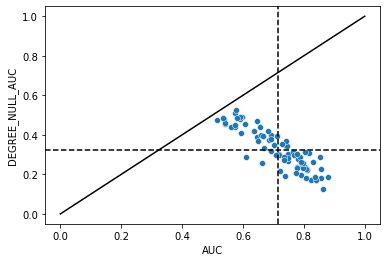

In [1443]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1448]:
df_2d_jac.sort_values('AUC').tail(20)

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value
cell_type                                                                
Pvalb Kank4      0.794059      3264.183788         0.252241  4.612579e-24
Sst Pvalb Calb2  0.796373      3579.386495         0.231239  3.085595e-06
Sst Th_2         0.797490      3209.281056         0.255620  2.932289e-12
Lamp5 Egln3_3    0.803361      3144.661922         0.237786  2.663758e-48
Sncg Col14a1     0.803797      3642.503006         0.315525  6.646905e-04
Sst Tac2         0.806578      2948.819445         0.180393  2.545760e-13
Sst Crhr2_1      0.808040      3249.238553         0.229208  7.150684e-25
L5/6 NP_1        0.809142      3100.731550         0.226246  1.566970e-14
Pvalb Il1rapl2   0.809229      3157.387649         0.220980  1.145872e-26
L5 PT_3          0.815507      3511.286898         0.308281  9.287629e-27
Sst C1ql3_2      0.824792      2904.264508         0.172056  7.641504e-16
Vip Chat_2       0.829912      3254.348300         0.262497  4.105930e-15
Vip Igfbp6_2     0.836475      2981.558867         0.185219  1.948949e-16
Sst Crhr2_2      0.839893      2441.539108         0.172821  6.217317e-08
Sst C1ql3_1      0.840508      3049.911349         0.170447  4.265060e-17
L5/6 NP CT       0.851564      3117.438456         0.286579  2.634787e-07
Lamp5 Pdlim5_2   0.855758      3147.368510         0.226360  1.087074e-04
Lamp5 Pax6       0.856232      3009.400941         0.179794  2.059688e-08
L5 IT_3          0.864525      3085.396891         0.128305  6.640824e-05
Pvalb Reln       0.880935      2932.043714         0.187021  7.082721e-09

In [1292]:
df_jac_corr.min()

ENSMUSG00000102693    0.003136
ENSMUSG00000064842    0.002995
ENSMUSG00000051951    0.000089
ENSMUSG00000102851    0.003114
ENSMUSG00000103377    0.002927
                        ...   
ENSMUSG00000070263    0.000967
ENSMUSG00000094649    0.001762
ENSMUSG00000069475    0.000708
ENSMUSG00000059326    0.002858
ENSMUSG00000095993    0.001743
Length: 50225, dtype: float64

In [1280]:
df_jac_corr.min().min()

9.910695886843628e-10

In [1294]:
df_jac_corr['non-gene']

KeyError: 'non-gene'

In [1231]:
df_2d_jac['AUC'].mean()

0.6631469905200643

In [1260]:
y = marker_table
#y =  marker_table.drop(columns=['Non-Neuronal'])
#y = y.loc[(y.sum(axis=1) != 0), (y.sum(axis=0) != 0)]
#y = y.sort_values(by=['GABAergic', 'Glutamatergic', 'Non-Neuronal'])
genes_intersect = y.index.intersection(df_max_gene_whole_by_bins.index)
#genes_intersect = marker_list.gene_id
nw = (df_max_gene_whole_by_bins.loc[genes_intersect, :])

marker_table = y.loc[genes_intersect, :]

species= y.idxmax(axis=1)

lut = dict(zip(species.unique(), sns.color_palette("hls", 85)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
lut = dict(zip(species.unique(), "rgb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)



#nw = (nw.loc[genes_intersect, 'non-gene'])

nw = nw.loc[(nw.sum(axis=1) != 0), (nw.sum(axis=0) != 0)]



In [1267]:
nw.to_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/nw_cluster_marker_vs_all_bin_index.csv_2.gz', sep='\t')



In [1266]:
nw.std(axis=0).to_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/nw_cluster_marker_vs_all_bin_index_std.csv', sep='\t')

In [1264]:
nw.shape

(6387, 150041)

In [1242]:
nw.shape

(6387, 150041)

In [1243]:
nw.shape

(6387, 150041)

In [1246]:
pwd

'/grid/gillis/home/lohia'

In [1247]:
nw.to_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/nw_cluster_marker_vs_all_bin_index.csv', sep='\t')

IsADirectoryError: [Errno 21] Is a directory: '/grid/gillis/data/lohia/hi_c_data_processing/notebooks'

In [1229]:
nw = nw.loc[(nw.sum(axis=1) != 0), (nw.std(axis=0) <= 10)]

nw.std(axis=0).median()

nw.shape

import h5py
import scipy.sparse as ss
import os
import sys
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from itertools import combinations
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
from sklearn.metrics.pairwise import pairwise_distances
from scipy import stats
import pyranges as pr


def pearson_corr(arr):
    
    #pearson_matrix = np.corrcoef(arr.toarray())
    pearson_matrix = np.corrcoef(arr)

    return pearson_matrix

rank_abs = lambda x: stats.rankdata(x)
arr2 = np.apply_along_axis(rank_abs, 1, nw.to_numpy())
                                

nw_pearson = pearson_corr(arr2)

nw_pearson.shape

df_non_bin_corr = pd.DataFrame(nw_pearson ,  index=nw.index.tolist(), columns = nw.index.tolist())

In [1281]:
df_non_bin_corr

ENSMUSG00000000056  ENSMUSG00000000058  \
ENSMUSG00000000056            1.000000            0.024844   
ENSMUSG00000000058            0.024844            1.000000   
ENSMUSG00000000078            0.032847            0.015001   
ENSMUSG00000000085            0.018940           -0.019111   
ENSMUSG00000000088            0.025265            0.024138   
...                                ...                 ...   
ENSMUSG00000115529           -0.013956           -0.007176   
ENSMUSG00000115783            0.028821            0.007719   
ENSMUSG00000116165            0.017347            0.016581   
ENSMUSG00000116429            0.021582            0.013848   
ENSMUSG00000116673            0.025676           -0.016627   

                    ENSMUSG00000000078  ENSMUSG00000000085  \
ENSMUSG00000000056            0.032847            0.018940   
ENSMUSG00000000058            0.015001           -0.019111   
ENSMUSG00000000078            1.000000            0.014546   
ENSMUSG00000000085            0.014546            1.000000   
ENSMUSG00000000088            0.021239            0.004494   
...                                ...                 ...   
ENSMUSG00000115529           -0.027115           -0.001812   
ENSMUSG00000115783            0.017776           -0.003858   
ENSMUSG00000116165            0.020968           -0.006779   
ENSMUSG00000116429            0.006105           -0.000782   
ENSMUSG00000116673            0.005860            0.049312   

                    ENSMUSG00000000088  ENSMUSG00000000120  \
ENSMUSG00000000056            0.025265            0.082031   
ENSMUSG00000000058            0.024138            0.020884   
ENSMUSG00000000078            0.021239            0.034185   
ENSMUSG00000000085            0.004494            0.018029   
ENSMUSG00000000088            1.000000            0.029852   
...                                ...                 ...   
ENSMUSG00000115529           -0.000033           -0.005240   
ENSMUSG00000115783            0.038929            0.023574   
ENSMUSG00000116165            0.035454            0.021994   
ENSMUSG00000116429            0.021847            0.013463   
ENSMUSG00000116673            0.016831            0.004695   

                    ENSMUSG00000000125  ENSMUSG00000000126  \
ENSMUSG00000000056            0.079871            0.069332   
ENSMUSG00000000058            0.010946            0.018271   
ENSMUSG00000000078            0.023819            0.036420   
ENSMUSG00000000085            0.055280            0.038767   
ENSMUSG00000000088            0.028287            0.020530   
...                                ...                 ...   
ENSMUSG00000115529           -0.008221           -0.001539   
ENSMUSG00000115783            0.038867            0.033925   
ENSMUSG00000116165            0.015983            0.025318   
ENSMUSG00000116429            0.012736            0.014623   
ENSMUSG00000116673            0.030925            0.011080   

                    ENSMUSG00000000168  ENSMUSG00000000171  ...  \
ENSMUSG00000000056            0.023571            0.033568  ...   
ENSMUSG00000000058            0.016503            0.031610  ...   
ENSMUSG00000000078            0.042475            0.025157  ...   
ENSMUSG00000000085            0.034424            0.001354  ...   
ENSMUSG00000000088            0.074264            0.067938  ...   
...                                ...                 ...  ...   
ENSMUSG00000115529           -0.013178           -0.000831  ...   
ENSMUSG00000115783            0.032663            0.043453  ...   
ENSMUSG00000116165            0.007829            0.038605  ...   
ENSMUSG00000116429            0.030129            0.023824  ...   
ENSMUSG00000116673            0.029327            0.010410  ...   

                    ENSMUSG00000113960  ENSMUSG00000114028  \
ENSMUSG00000000056            0.018630            0.032075   
ENSMUSG00000000058            0.005270           -0.021842   
ENSMUSG00000000078            0.142024           

In [1215]:
nw.std(axis=0).median()

64.45333099365234

In [1173]:
df_class_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

In [1177]:
df_class_marker = df_class_marker.drop_duplicates('cell_type')

In [1181]:
df_class_marker

group   cell_type  rank      gene  recurrence     auroc  \
0          GABAergic       Lamp5     1  Cacna2d1           7  0.918146   
1000       GABAergic       Pvalb     1     Pvalb           7  0.908463   
2000       GABAergic        Sncg     1      Cnr1           7  0.968239   
3000       GABAergic         Sst     1       Sst           7  0.951460   
4000       GABAergic         Vip     1       Vip           7  0.922197   
5000   Glutamatergic     L2/3 IT     1   Rasgrf2           7  0.874715   
6000   Glutamatergic       L5 ET     1    Gm2164           7  0.932605   
7000   Glutamatergic       L5 IT     1   Slc24a3           7  0.815052   
8000   Glutamatergic     L5/6 NP     1     Tshz2           7  0.988350   
9000   Glutamatergic       L6 CT     1     Foxp2           7  0.942359   
10000  Glutamatergic       L6 IT     1   Galnt14           7  0.844825   
11000  Glutamatergic  L6 IT Car3     1     Synpr           4  0.985914   
12000  Glutamatergic         L6b     1    Inpp4b           7  0.930382   

       fold_change  fold_change_detection   expression  precision    recall  \
0        10.042314               2.918454   679.620180   0.421814  0.920170   
1000     51.890543              10.259585   548.793187   0.730363  0.835400   
2000     10.029039               1.791292  3250.949738   0.062676  0.977336   
3000    131.622843               6.243620  2996.160064   0.674665  0.920548   
4000     44.318331               5.790294  5766.137065   0.632019  0.881093   
5000      8.544493               3.443147   250.674531   0.475482  0.825780   
6000     17.273722               6.952110   230.624723   0.159251  0.912025   
7000      6.194582               2.648420   230.492660   0.584156  0.788087   
8000    166.750153              11.835138  2145.051266   0.362030  0.979409   
9000     23.198230               5.332981   447.828075   0.600898  0.913473   
10000     6.796150               3.412028   254.188308   0.250478  0.815586   
11000    39.684105               3.652890  1800.695611   0.015798  0.983788   
12000    25.615801               5.404430   600.009493   0.181291  0.907925   

       population_size  n_datasets  scSS  snSS  scCv2  snCv2 snCv3M  scCv3  \
0          2037.857143           7  True  True   True   True   True   True   
1000       2605.428571           7  True  True   True   True   True   True   
2000        397.571429           7  True  True   True   True   True   True   
3000       2647.428571           7  True  True   True   True   True   True   
4000       2499.857143           7  True  True   True   True   True   True   
5000      12214.285714           7  True  True   True   True   True   True   
6000       1374.285714           7  True  True   True   True   True   True   
7000      17987.000000           7  True  True   True   True   True   True   
8000       2103.000000           7  True  True   True   True   True   True   
9000      10768.285714           7  True  True   True   True   True   True   
10000      4230.571429           7  True  True   True   True   True   True   
11000       253.250000           4  True   NaN   True   True    NaN   True   
12000      1018.571429           7  True  True   True   True   True   True   

      snCv3Z  
0       True  
1000    True  
2000    True  
3000    True  
4000    True  
5000    True  
6000    True  
7000    True  
8000    True  
9000    True  
10000   True  
11000    NaN  
12000   True

In [1180]:
df_2d_jac.reset_index()

cell_type       AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value
0        L2/3 IT_1  0.693352      3800.533374         0.401581  2.016587e-06
1        L2/3 IT_2  0.741636      3661.371066         0.344240  8.205662e-31
2        L4/5 IT_1  0.574568      4153.098312         0.440798  4.198951e-15
3        L4/5 IT_2  0.595687      4238.047506         0.492758  1.888820e-23
4          L5 IT_2  0.635556      4025.250460         0.421213  3.444528e-11
..             ...       ...              ...              ...           ...
75    Vip Mybpc1_3  0.736395      3604.468261         0.272962  1.928416e-04
76  Vip Serpinf1_1  0.662341      3707.046656         0.259075  2.523407e-03
77  Vip Serpinf1_2  0.680942      4017.120347         0.421130  8.909665e-42
78  Vip Serpinf1_3  0.778470      3593.576411         0.302089  4.392372e-11
79        Vip Sncg  0.665195      3894.974207         0.394146  2.536440e-35

[80 rows x 5 columns]

In [1248]:
nw

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000000056            0.367957            0.255779   
ENSMUSG00000000058            0.000000            0.999205   
ENSMUSG00000000078            1.917503            0.801660   
ENSMUSG00000000085            1.832486            1.607832   
ENSMUSG00000000088            0.577799            0.000000   
...                                ...                 ...   
ENSMUSG00000115529            1.183030            0.796412   
ENSMUSG00000115783            0.432659            0.542652   
ENSMUSG00000116165            0.690594            0.000000   
ENSMUSG00000116429            0.961848            0.000000   
ENSMUSG00000116673            1.784591            1.179751   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000000056            1.641808            0.630834   
ENSMUSG00000000058            2.398370            0.455277   
ENSMUSG00000000078            2.533577            1.095805   
ENSMUSG00000000085            3.495824            1.566642   
ENSMUSG00000000088            1.697405            0.660395   
...                                ...                 ...   
ENSMUSG00000115529            2.887117            0.000000   
ENSMUSG00000115783            1.479781            0.247254   
ENSMUSG00000116165            1.686610            1.183972   
ENSMUSG00000116429            1.366655            0.549672   
ENSMUSG00000116673            2.705244            1.185007   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000000056            0.559241            0.669487   
ENSMUSG00000000058            2.398370            0.000000   
ENSMUSG00000000078            0.641403            0.245689   
ENSMUSG00000000085            0.964812            1.111386   
ENSMUSG00000000088            0.346560            0.837811   
...                                ...                 ...   
ENSMUSG00000115529            1.780751            2.310668   
ENSMUSG00000115783            0.000000            0.000000   
ENSMUSG00000116165            0.346505            0.209420   
ENSMUSG00000116429            0.000000            0.291676   
ENSMUSG00000116673            1.163213            1.901594   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000000056            0.560594            1.154503   
ENSMUSG00000000058            0.801391            1.617121   
ENSMUSG00000000078            1.607388            1.729885   
ENSMUSG00000000085            0.919215            3.495824   
ENSMUSG00000000088            0.871834            1.697405   
...                                ...                 ...   
ENSMUSG00000115529            1.785060            2.214158   
ENSMUSG00000115783            0.000000            0.488316   
ENSMUSG00000116165            0.347343            0.623280   
ENSMUSG00000116429            0.000000            1.301604   
ENSMUSG00000116673            0.996600            2.705244   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...   non-gene  \
ENSMUSG00000000056            1.103880            0.463620  ...   1.773425   
ENSMUSG00000000058            1.617121            0.452784  ...   0.295360   
ENSMUSG00000000078            1.729885            0.363268  ...   0.947867   
ENSMUSG00000000085            1.301064            0.835977  ...   0.950535   
ENSMUSG00000000088            0.934683            0.392558  ...   1.792515   
...                                ...                 ...  ...        ...   
ENSMUSG00000115529            1.219234            2.887117  ...   0.438600   
ENSMUSG00000115783            0.000000            1.475398  ...   3.528913   
ENSMUSG00000116165            0.000000            0.588744  ...   0.768099   
ENSMUSG00000116429            1.301604            1.366655  ...   0.891496   
ENSMUSG00000116673            1.207483            1.677396  ...  10.056464   

                    non-gene   non-gene   non-gene   non-gene   non-gene  \
ENSMUSG00000000056  1.91979

In [1179]:
df_2d_jac.reset_index().merge(df_class_marker)

Empty DataFrame
Columns: [cell_type, AUC, AVG_NODE_DEGREE, DEGREE_NULL_AUC, P_Value, group, rank, gene, recurrence, auroc, fold_change, fold_change_detection, expression, precision, recall, population_size, n_datasets, scSS, snSS, scCv2, snCv2, snCv3M, scCv3, snCv3Z]
Index: []

[0 rows x 24 columns]

In [1121]:
marker_table

Empty DataFrame
Columns: []
Index: []

In [1134]:
y = marker_table
#y = y.sort_values(by=['GABAergic', 'Glutamatergic', 'Non-Neuronal'])
genes_intersect = y.index.intersection(df_max_gene_whole.index)
#genes_intersect = marker_list.gene_id
nw = (df_max_gene_whole.loc[genes_intersect, 'non-gene'])

marker_table = y.loc[genes_intersect, :]

species= y.idxmax(axis=1)

lut = dict(zip(species.unique(), sns.color_palette("hls", 85)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
lut = dict(zip(species.unique(), "rgb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)



In [1135]:
nw = nw.loc[(nw.sum(axis=1) != 0), (nw.sum(axis=0) != 0)]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


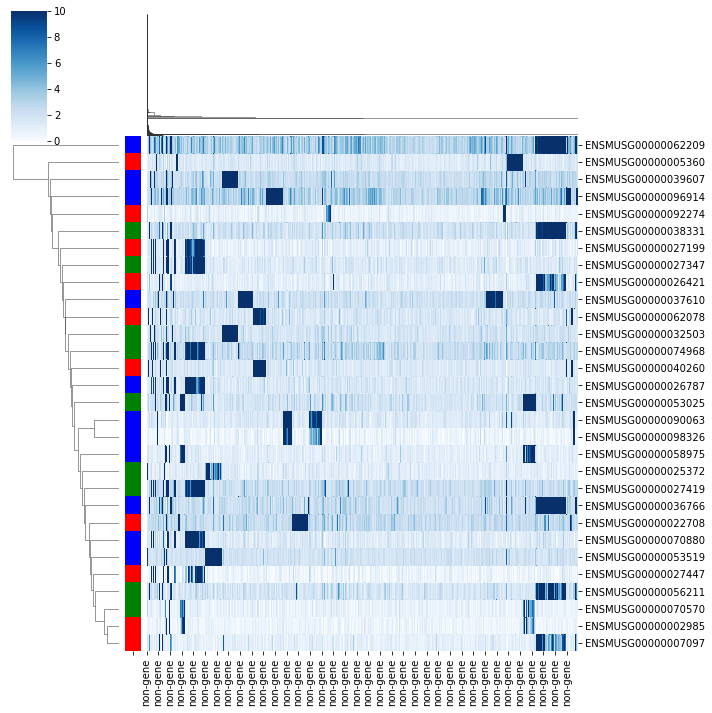

In [1136]:
g = sns.clustermap(nw, row_colors=row_colors,  cmap="Blues", vmax=10)

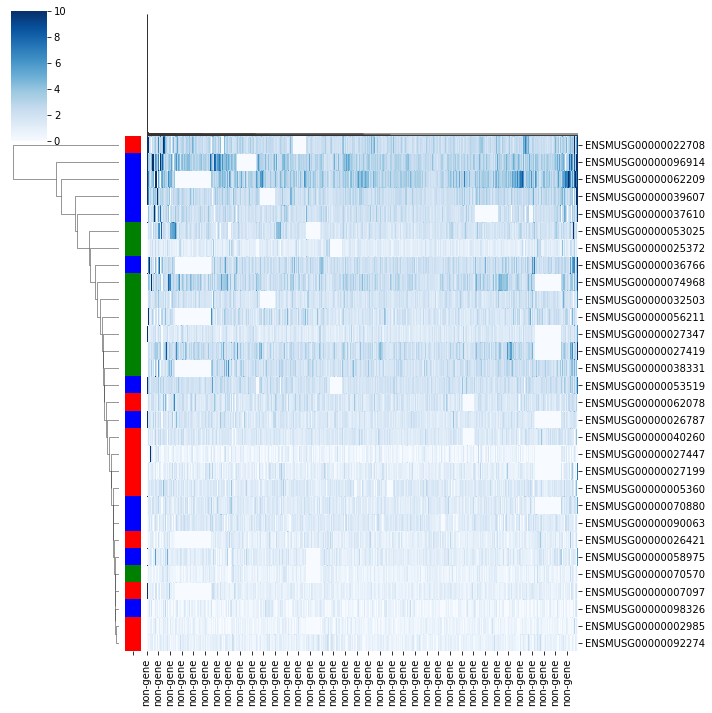

In [1075]:
g = sns.clustermap(nw, row_colors=row_colors,  cmap="Blues", vmax=10)

In [ ]:
g = sns.clustermap(nw, row_colors=row_colors,  cmap="Blues")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


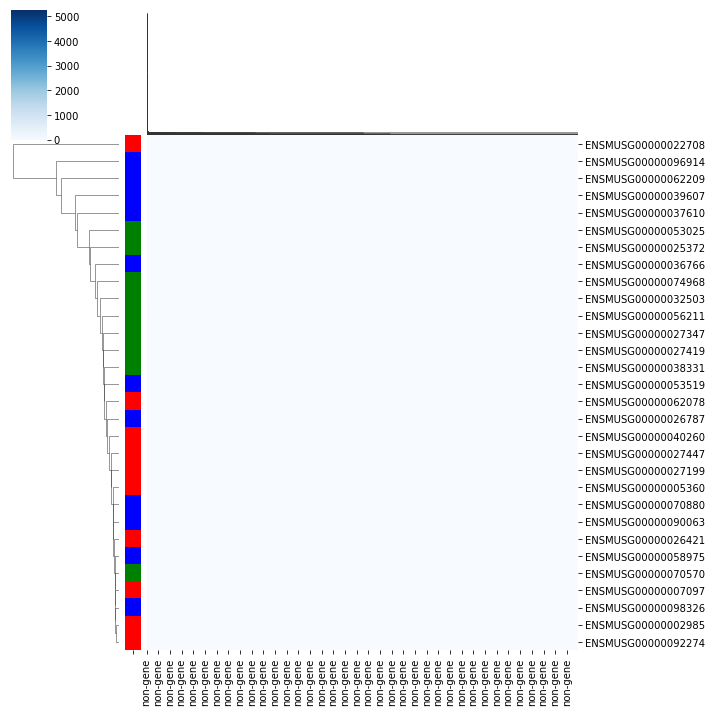

In [1067]:
g = sns.clustermap(nw, row_colors=row_colors,  cmap="Blues")

In [1048]:
df_dist = nw.max().max()-nw
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_dist = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-1048-e3971396f9ad>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


ValueError: The matrix argument must be square.

In [267]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
marker_list['gene'] = marker_list['gene'].str.upper()
#marker_list = marker_list[marker_list['rank'] < 250] 


In [316]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')



In [317]:
df_optimal_marker[df_optimal_marker['hierarchy_level'] == 'subclass']

hierarchy_level marker_set  n_genes        f1
1171        subclass    L2/3 IT        1  0.601276
1172        subclass    L2/3 IT        2  0.687854
1173        subclass    L2/3 IT        5  0.786807
1174        subclass    L2/3 IT       10  0.847541
1175        subclass    L2/3 IT       20  0.863682
...              ...        ...      ...       ...
1335        subclass        Vip      500  0.935080
1336        subclass        Vip     1000  0.904264
1337        subclass        Vip     2000  0.823741
1338        subclass        Vip     5000  0.674320
1339        subclass        Vip    10000  0.637578

[169 rows x 4 columns]

In [105]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')


df_optimal_marker['n_genes'].diff()

df_optimal_marker['f1'].diff() / 

df_optimal_marker.diff() / df_optimal_marker.index.to_series().diff().dt.total_seconds()

df_optimal_marker[df_optimal_marker['hierarchy_level'] == 'class']

SyntaxError: invalid syntax (<ipython-input-105-39f6cfeed71d>, line 6)

In [963]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')
marker_list['gene'] = marker_list['gene'].str.upper()
#marker_list = marker_list[marker_list['rank'] < 250] 


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [964]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')
df_optimal_marker = df_optimal_marker[df_optimal_marker['n_genes'] >= 10]
#df_optimal_marker = df_optimal_marker[df_optimal_marker['n_genes'] <= 500]
#df_optimal_marker['f1'] = [0 if x > 0.8 else x for x in df_optimal_marker['f1']]
#df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] <= 0.8]
#df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] >= 0.8]
df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmax()]
#df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmin()]


In [882]:
marker_list['cell_type'] = np.random.permutation(marker_list['cell_type'].values)

In [914]:
marker_list['gene'] = np.random.permutation(marker_list['gene'].values)

In [915]:
marker_list = marker_list.drop_duplicates(subset=['cell_type', 'gene'])

In [885]:
marker_list.head(10)

group       cell_type  rank    gene  recurrence     auroc  fold_change  \
0  L2/3 IT  Vip Serpinf1_3     1   EPHA4           5  0.842734     5.410202   
1  L2/3 IT     Sst Crhr2_1     2  CHRNB3           5  0.752062     7.557666   
2  L2/3 IT      Sst Myh8_3     3   PROX1           5  0.702306    12.460411   
3  L2/3 IT       L2/3 IT_2     4  SNAPC1           5  0.702247     9.147210   
4  L2/3 IT    Sncg Col14a1     5   KCNE4           5  0.696202     6.217147   
5  L2/3 IT      Sst Myh8_1     6  CEP350           4  0.774556     5.448440   
6  L2/3 IT         L5 PT_2     7   TUBE1           4  0.750407     6.124970   
7  L2/3 IT    Sncg Calb1_2     8    DLAT           4  0.681915     4.679975   
8  L2/3 IT         L5 IT_3     9   TIAM2           4  0.680789     4.979310   
9  L2/3 IT      Sst Myh8_3    10  SNCAIP           4  0.640997     5.642979   

   fold_change_detection  expression  precision    recall  population_size  \
0               2.606655  255.840030   0.095304  0.830882       492.833333   
1               4.621909   99.357999   0.152135  0.582932       492.833333   
2               7.980352   61.676311   0.219897  0.446298       492.833333   
3               6.442665   53.928589   0.201546  0.445979       492.833333   
4               3.645296   59.489654   0.121974  0.479271       492.833333   
5               2.865220  161.704625   0.098252  0.684696       492.833333   
6               2.805338  153.985829   0.095208  0.631181       492.833333   
7               3.341628   70.327004   0.118642  0.469068       492.833333   
8               4.026078   43.891351   0.129846  0.439023       492.833333   
9               5.341248   31.052204   0.165736  0.336479       492.833333   

   n_datasets scSS   snSS scCv2  snCv2  snCv3M scCv3 snCv3Z  
0           6  NaN  False  True   True    True  True   True  
1           6  NaN  False  True   True    True  True   True  
2           6  NaN  False  True   True    True  True   True  
3           6  NaN  False  True   True    True  True   True  
4           6  NaN  False  True   True    True  True   True  
5           6  NaN  False  True  False    True  True   True  
6           6  NaN  False  True  False    True  True   True  
7           6  NaN  False  True  False    True  True   True  
8           6  NaN  False  True  False    True  True   True  
9           6  NaN  False  True  False    True  True   True

In [965]:
marker_list_optimal_marker = []
for marker, n_genes in zip(df_optimal_marker['marker_set'].tolist(), df_optimal_marker['n_genes'].tolist()):
    #print (n_genes)
    #marker_list_optimal_marker.append(marker_list[(marker_list['cell_type'] == marker) & (marker_list['rank'] >= (1000 - n_genes ))])
    
    marker_list_optimal_marker.append(marker_list[(marker_list['cell_type'] == marker) & (marker_list['rank'] <= 10)])
    

In [966]:
marker_list = pd.concat(marker_list_optimal_marker)

In [967]:
marker_list

group  cell_type  rank           gene  recurrence     auroc  \
0      L2/3 IT  L2/3 IT_1     1  6530403H02RIK           5  0.842734   
1      L2/3 IT  L2/3 IT_1     2        ADAMTS2           5  0.752062   
2      L2/3 IT  L2/3 IT_1     3        COL23A1           5  0.702306   
3      L2/3 IT  L2/3 IT_1     4            MET           5  0.702247   
4      L2/3 IT  L2/3 IT_1     5            UST           5  0.696202   
...        ...        ...   ...            ...         ...       ...   
53005     Sncg   Vip Sncg     6         ADRA1B           4  0.885241   
53006     Sncg   Vip Sncg     7          CBLN2           4  0.748158   
53007     Sncg   Vip Sncg     8          VWC2L           4  0.731883   
53008     Sncg   Vip Sncg     9          TIAM1           4  0.729949   
53009     Sncg   Vip Sncg    10          CDH20           4  0.672793   

       fold_change  fold_change_detection  expression  precision    recall  \
0         5.410202               2.606655  255.840030   0.095304  0.830882   
1         7.557666               4.621909   99.357999   0.152135  0.582932   
2        12.460411               7.980352   61.676311   0.219897  0.446298   
3         9.147210               6.442665   53.928589   0.201546  0.445979   
4         6.217147               3.645296   59.489654   0.121974  0.479271   
...            ...                    ...         ...        ...       ...   
53005     5.076560               2.207089  516.423589   0.362175  0.940482   
53006     4.094658               1.896812  217.716061   0.327322  0.700719   
53007     5.827125               3.351171  151.922461   0.460959  0.612961   
53008     4.658092               1.985488   88.840756   0.339742  0.637112   
53009     7.667269               7.084261   49.476083   0.615152  0.402219   

       population_size  n_datasets   scSS   snSS scCv2  snCv2  snCv3M  scCv3  \
0           492.833333           6    NaN  False  True   True    True   True   
1           492.833333           6    NaN  False  True   True    True   True   
2           492.833333           6    NaN  False  True   True    True   True   
3           492.833333           6    NaN  False  True   True    True   True   
4           492.833333           6    NaN  False  True   True    True   True   
...                ...         ...    ...    ...   ...    ...     ...    ...   
53005        78.000000           7  False  False  True   True    True  False   
53006        78.000000           7   True  False  True  False    True   True   
53007        78.000000           7  False  False  True  False    True   True   
53008        78.000000           7   True  False  True  False    True   True   
53009        78.000000           7  False  False  True  False    True   True   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
53005   True  
53006  False  
53007   True  
53008  False  
53009   True  

[850 rows x 20 columns]

In [968]:
np.random.permutation([1, 4, 9, 12, 15])

array([ 1,  9, 12,  4, 15])

In [969]:
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 


In [970]:
marker_list

group       cell_type  rank           gene  recurrence     auroc  \
0    L2/3 IT       L2/3 IT_1     1  6530403H02RIK           5  0.842734   
1    L2/3 IT       L2/3 IT_1     2        ADAMTS2           5  0.752062   
2    L2/3 IT       L2/3 IT_1     3        COL23A1           5  0.702306   
3      L5 PT         L5 PT_4     4        COL23A1           5  0.703758   
4      L6 CT    L6 CT Gpr139     2        COL23A1           6  0.876877   
..       ...             ...   ...            ...         ...       ...   
831      Vip  Vip Serpinf1_3     9         IGSF11           5  0.908502   
832      Vip  Vip Serpinf1_3    10          FGF13           5  0.906381   
833     Sncg        Vip Sncg     1            VIP           7  0.972235   
834     Sncg        Vip Sncg     6         ADRA1B           4  0.885241   
835     Sncg        Vip Sncg     9          TIAM1           4  0.729949   

     fold_change  fold_change_detection    expression  precision  ...  \
0       5.410202               2.606655    255.840030   0.095304  ...   
1       7.557666               4.621909     99.357999   0.152135  ...   
2      12.460411               7.980352     61.676311   0.219897  ...   
3      16.281992              17.252232     37.491465   0.705847  ...   
4       9.270173               7.009485    128.748554   0.048327  ...   
..           ...                    ...           ...        ...  ...   
831    10.879272               6.314092    192.629420   0.095909  ...   
832     2.697688               1.747461    706.810226   0.025372  ...   
833    13.160630               2.226559  11357.946158   0.361444  ...   
834     5.076560               2.207089    516.423589   0.362175  ...   
835     4.658092               1.985488     88.840756   0.339742  ...   

     population_size  n_datasets   scSS   snSS scCv2  snCv2 snCv3M  scCv3  \
0         492.833333           6    NaN  False  True   True   True   True   
1         492.833333           6    NaN  False  True   True   True   True   
2         492.833333           6    NaN  False  True   True   True   True   
3         265.000000           7  False  False  True   True   True   True   
4          79.714286           7   True  False  True   True   True   True   
..               ...         ...    ...    ...   ...    ...    ...    ...   
831        45.000000           7   True  False  True  False   True   True   
832        45.000000           7   True  False  True  False   True   True   
833        78.000000           7   True   True  True   True   True   True   
834        78.000000           7  False  False  True   True   True  False   
835        78.000000           7   True  False  True  False   True   True   

    snCv3Z             gene_id  
0     True  ENSMUSG00000098097  
1     True  ENSMUSG00000036545  
2     True  ENSMUSG00000063564  
3     True  ENSMUSG00000063564  
4     True  ENSMUSG00000063564  
..     ...                 ...  
831   True  ENSMUSG00000022790  
832   True  ENSMUSG00000031137  
833   True  ENSMUSG00000019772  
834   True  ENSMUSG00000050541  
835  False  ENSMUSG00000002489  

[836 rows x 21 columns]

In [971]:
marker_table = marker_list.pivot(index='gene_id', columns='cell_type', values='rank')

In [972]:
marker_list

group       cell_type  rank           gene  recurrence     auroc  \
0    L2/3 IT       L2/3 IT_1     1  6530403H02RIK           5  0.842734   
1    L2/3 IT       L2/3 IT_1     2        ADAMTS2           5  0.752062   
2    L2/3 IT       L2/3 IT_1     3        COL23A1           5  0.702306   
3      L5 PT         L5 PT_4     4        COL23A1           5  0.703758   
4      L6 CT    L6 CT Gpr139     2        COL23A1           6  0.876877   
..       ...             ...   ...            ...         ...       ...   
831      Vip  Vip Serpinf1_3     9         IGSF11           5  0.908502   
832      Vip  Vip Serpinf1_3    10          FGF13           5  0.906381   
833     Sncg        Vip Sncg     1            VIP           7  0.972235   
834     Sncg        Vip Sncg     6         ADRA1B           4  0.885241   
835     Sncg        Vip Sncg     9          TIAM1           4  0.729949   

     fold_change  fold_change_detection    expression  precision  ...  \
0       5.410202               2.606655    255.840030   0.095304  ...   
1       7.557666               4.621909     99.357999   0.152135  ...   
2      12.460411               7.980352     61.676311   0.219897  ...   
3      16.281992              17.252232     37.491465   0.705847  ...   
4       9.270173               7.009485    128.748554   0.048327  ...   
..           ...                    ...           ...        ...  ...   
831    10.879272               6.314092    192.629420   0.095909  ...   
832     2.697688               1.747461    706.810226   0.025372  ...   
833    13.160630               2.226559  11357.946158   0.361444  ...   
834     5.076560               2.207089    516.423589   0.362175  ...   
835     4.658092               1.985488     88.840756   0.339742  ...   

     population_size  n_datasets   scSS   snSS scCv2  snCv2 snCv3M  scCv3  \
0         492.833333           6    NaN  False  True   True   True   True   
1         492.833333           6    NaN  False  True   True   True   True   
2         492.833333           6    NaN  False  True   True   True   True   
3         265.000000           7  False  False  True   True   True   True   
4          79.714286           7   True  False  True   True   True   True   
..               ...         ...    ...    ...   ...    ...    ...    ...   
831        45.000000           7   True  False  True  False   True   True   
832        45.000000           7   True  False  True  False   True   True   
833        78.000000           7   True   True  True   True   True   True   
834        78.000000           7  False  False  True   True   True  False   
835        78.000000           7   True  False  True  False   True   True   

    snCv3Z             gene_id  
0     True  ENSMUSG00000098097  
1     True  ENSMUSG00000036545  
2     True  ENSMUSG00000063564  
3     True  ENSMUSG00000063564  
4     True  ENSMUSG00000063564  
..     ...                 ...  
831   True  ENSMUSG00000022790  
832   True  ENSMUSG00000031137  
833   True  ENSMUSG00000019772  
834   True  ENSMUSG00000050541  
835  False  ENSMUSG00000002489  

[836 rows x 21 columns]

In [973]:
marker_table.fillna(0, inplace=True)

In [974]:
marker_table[marker_table != 0] = 1

(526, 526)
(526, 85)
0.981816148512637
0.0


<ipython-input-7-cc54342b63f9>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


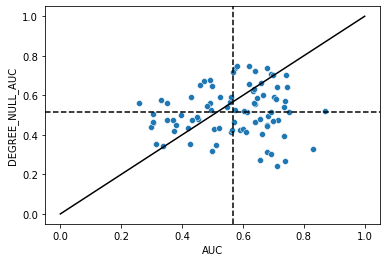

In [975]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[2])
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [960]:
df_2d_jac['AUC'].mean()

0.619466019740627

In [762]:
df_2d_jac['AUC'].mean()

0.6083322739197063

(10812, 10812)
(10812, 85)
0.9176111510086832
0.0


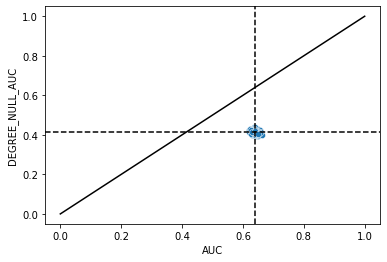

In [778]:
df_2d_exp, go_chrom  = run_egad(marker_table, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_exp, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_exp['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_exp['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [779]:
df_2d_exp['AUC'].mean()

0.6383083090649919

In [467]:
df_exp_hic = df_2d_jac.merge(df_2d_exp, left_on=df_2d_jac.index, right_on=df_2d_exp.index)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AUC (co-exp)')

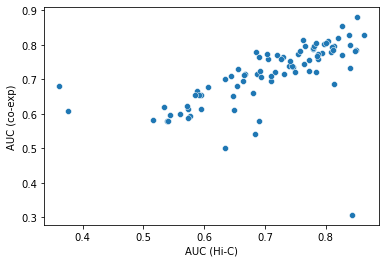

In [480]:
ax = sns.scatterplot(df_exp_hic['AUC_x'], df_exp_hic['AUC_y'])
ax.set_xlabel('AUC (Hi-C)')
ax.set_ylabel('AUC (co-exp)')

In [471]:
df_exp_hic.sort_values(['AUC_x']).tail(20)

key_0     AUC_x  AVG_NODE_DEGREE_x  DEGREE_NULL_AUC_x  \
44     Pvalb Kank4  0.794582        3265.604432           0.252188   
50    Sncg Col14a1  0.796782        3644.126231           0.315423   
67        Sst Tac2  0.800141        2950.068896           0.180366   
32   Lamp5 Egln3_3  0.804303        3146.021908           0.237748   
14       L5/6 NP_1  0.808636        3102.064917           0.226192   
43  Pvalb Il1rapl2  0.810919        3158.742840           0.220938   
56     Sst Crhr2_1  0.811876        3250.645288           0.229152   
11         L5 PT_3  0.813567        3512.818842           0.308225   
16       L5/6 NP_3  0.813819        3215.650621           0.310533   
15       L5/6 NP_2  0.819578        3342.181766           0.196666   
73      Vip Chat_2  0.827632        3255.737402           0.262420   
54     Sst C1ql3_2  0.827643        2905.493057           0.172006   
13      L5/6 NP CT  0.838822        3118.763231           0.286523   
53     Sst C1ql3_1  0.840041        3051.197048           0.170397   
57     Sst Crhr2_2  0.840418        2442.617124           0.172802   
36  Lamp5 Pdlim5_2  0.843966        3148.697767           0.226332   
77    Vip Igfbp6_2  0.848834        2982.811631           0.185176   
34      Lamp5 Pax6  0.849822        3010.640376           0.179757   
7          L5 IT_3  0.851480        3086.703653           0.128260   
45      Pvalb Reln  0.862708        2933.237327           0.186999   

       P_Value_x     AUC_y  AVG_NODE_DEGREE_y  DEGREE_NULL_AUC_y     P_Value_y  
44  3.066907e-24  0.777537        3267.256241           0.281771  3.017425e-21  
50  5.852151e-04  0.801420        3589.869845           0.360966  7.914001e-04  
67  5.602384e-13  0.804597        2962.487769           0.209790  2.710819e-13  
32  1.787500e-48  0.811029        3113.505314           0.242667  1.764866e-50  
14  1.719034e-14  0.779066        3051.000696           0.225803  2.086843e-11  
43  1.064214e-26  0.793901        3136.960638           0.244701  1.050272e-23  
56  4.004409e-25  0.785826        3091.609910           0.226876  1.084679e-21  
11  1.220838e-26  0.796853        3412.415553           0.321459  2.423162e-24  
16  6.691331e-04  0.686426        3292.962170           0.280702  2.441120e-02  
15  4.788471e-06  0.820401        2971.522709           0.203976  1.322160e-05  
73  5.425298e-15  0.853116        2712.147927           0.163993  3.160676e-17  
54  5.552334e-16  0.771203        3014.604961           0.207861  5.619526e-11  
13  3.349440e-07  0.828687        2960.090242           0.225052  3.487057e-07  
53  4.915764e-17  0.732837        3077.714020           0.221073  1.730012e-08  
57  8.919463e-08  0.798362        2623.928089           0.156890  4.431943e-04  
36  1.433852e-04  0.307079        3004.373398           0.216318  5.488248e-02  
77  8.743658e-17  0.782259        3139.874573           0.238297  9.848926e-12  
34  2.926481e-08  0.784917        3233.030723           0.293944  7.424776e-06  
7   1.638079e-04  0.879838        2625.488025           0.161671  2.696118e-05  
45  2.055571e-08  0.828363        3158.021864           0.231596  7.060817e-07

In [425]:
marker_list['gene_id']

group      cell_type  rank     gene  recurrence     auroc  fold_change  \
0    all      GABAergic     1     GAD1           7  0.941159   116.960472   
1    all      GABAergic     2     GAD2           7  0.928440   139.811415   
2    all      GABAergic     3    ERBB4           7  0.921449    81.717383   
3    all      GABAergic     4   KCNIP1           7  0.916919    32.252038   
4    all      GABAergic     5    RBMS3           7  0.902093    17.038869   
5    all      GABAergic     6  DLX6OS1           7  0.888987   140.002208   
6    all      GABAergic     6  DLX6OS1           7  0.888987   140.002208   
7    all      GABAergic     7  GALNTL6           7  0.886959    10.894620   
8    all      GABAergic     8   KCNMB2           7  0.884982   100.916735   
9    all      GABAergic     9     DNER           7  0.877300    10.749567   
10   all      GABAergic    10    KCNC1           7  0.870661     8.574477   
11   all  Glutamatergic     1   ARPP21           7  0.975092     9.088639   
12   all  Glutamatergic     2    PCSK2           7  0.948771     5.975332   
13   all  Glutamatergic     3     SV2B           7  0.930621    22.505500   
14   all  Glutamatergic     4   R3HDM1           7  0.929113     4.672130   
15   all  Glutamatergic     5   BAIAP2           7  0.922301    10.045173   
16   all  Glutamatergic     6     ANO3           7  0.922224     9.273151   
17   all  Glutamatergic     7  SLC17A7           7  0.921349    22.692954   
18   all  Glutamatergic     8    SATB2           7  0.905836    27.292989   
19   all  Glutamatergic     9   CNKSR2           7  0.893200     5.549927   
20   all  Glutamatergic    10  RASGRP1           7  0.868011     8.671028   
21   all   Non-Neuronal     1       QK           7  0.896552    17.743711   
22   all   Non-Neuronal     2   ZBTB20           7  0.872153    11.458396   
23   all   Non-Neuronal     3     APOE           7  0.805082   150.205254   
24   all   Non-Neuronal     4     CST3           7  0.787178    26.230397   
25   all   Non-Neuronal     5   SLC1A3           7  0.749015   306.373716   
26   all   Non-Neuronal     6   ATP1A2           7  0.748797   154.193303   
27   all   Non-Neuronal     7    CSRP1           7  0.742733    80.918438   
28   all   Non-Neuronal     8    NEAT1           7  0.710544   101.027412   
29   all   Non-Neuronal     9    DAAM2           7  0.709976    72.133593   
30   all   Non-Neuronal    10     GATM           7  0.704289    54.012850   
31   all   Non-Neuronal    10     GATM           7  0.704289    54.012850   

    fold_change_detection   expression  precision  ...  population_size  \
0                9.289078   820.463486   0.659089  ...     10207.000000   
1               13.987046   659.151566   0.730005  ...     10207.000000   
2                5.736415  2257.167753   0.514809  ...     10207.000000   
3               10.796420   588.571993   0.687830  ...     10207.000000   
4                3.607831   340.701798   0.442861  ...     10207.000000   
5               35.287387   328.588268   0.868152  ...     10207.000000   
6               35.287387   328.588268   0.868152  ...     10207.000000   
7                2.060749  1346.116106   0.329006  ...     10207.000000   
8               27.129502   349.694368   0.810448  ...     10207.000000   
9                2.845851   497.548767   0.391116  ...     10207.000000   
10               1.996219   398.366785   0.315000  ...     10207.000000   
11               2.043554  1381.680094   0.857382  ...     49843.000000   
12               1.728900   852.335533   0.830496  ...     49843.000000   
13               6.576665   385.467183   0.949654  ...     49843.000000   
14               1.210654  1241.308386   0.774356  ...     49843.000000   
15               4.054475   359.970940   0.918787  ...     49843.000000   
16               3.662973   520.386438   0.916820  ...     49843.000000   
17               4.792771   428.341560   0.932910  ...     49843.000000   
18              11.132994   213.2361

In [443]:
marker_table.shape

(32, 3)

In [446]:
genes_intersect

0     ENSMUSG00000070880
1     ENSMUSG00000026787
2     ENSMUSG00000062209
3     ENSMUSG00000053519
4     ENSMUSG00000039607
5     ENSMUSG00000098326
6     ENSMUSG00000090063
7     ENSMUSG00000096914
8     ENSMUSG00000037610
9     ENSMUSG00000036766
10    ENSMUSG00000058975
11    ENSMUSG00000032503
12    ENSMUSG00000027419
13    ENSMUSG00000053025
14    ENSMUSG00000056211
15    ENSMUSG00000025372
16    ENSMUSG00000074968
17    ENSMUSG00000070570
18    ENSMUSG00000038331
19    ENSMUSG00000025658
20    ENSMUSG00000027347
21    ENSMUSG00000062078
22    ENSMUSG00000022708
23    ENSMUSG00000002985
24    ENSMUSG00000027447
25    ENSMUSG00000005360
26    ENSMUSG00000007097
27    ENSMUSG00000026421
28    ENSMUSG00000092274
29    ENSMUSG00000040260
30    ENSMUSG00000027199
31    ENSMUSG00000111138
Name: gene_id, dtype: object

In [447]:
y = marker_table
y = y.sort_values(by=['GABAergic', 'Glutamatergic', 'Non-Neuronal'])
genes_intersect = y.index.intersection(df_jac_corr_list[2].index)
#genes_intersect = marker_list.gene_id
nw = (df_jac_corr_list[2].loc[genes_intersect, genes_intersect])

marker_table = y.loc[genes_intersect, :]

species= y.idxmax(axis=1)

lut = dict(zip(species.unique(), sns.color_palette("hls", 3)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
lut = dict(zip(species.unique(), "rgb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)


In [408]:
lut

{'Non-Neuronal': 'r', 'Glutamatergic': 'g', 'GABAergic': 'b'}

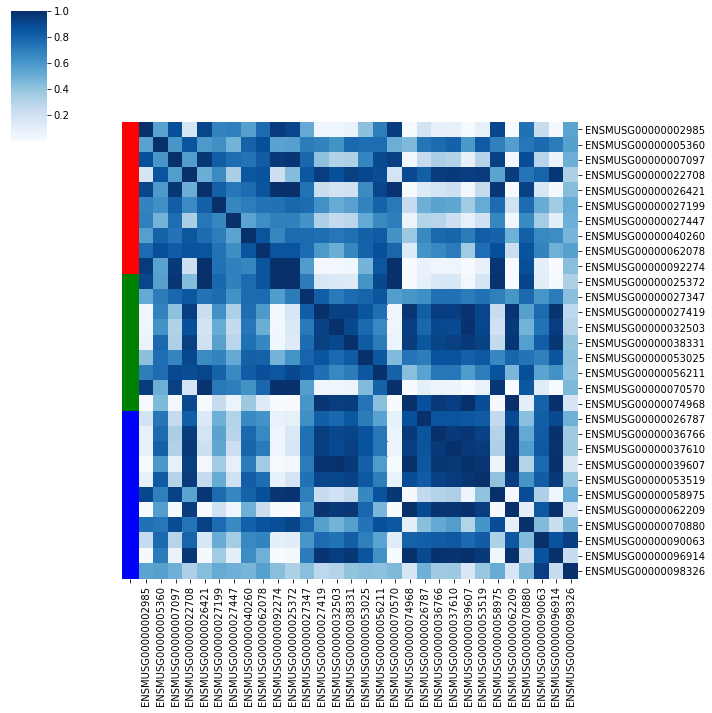

In [422]:
g = sns.clustermap(nw, row_colors=row_colors, row_cluster=False, col_cluster=False, cmap="Blues")

In [398]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [401]:
nw

ENSMUSG00000002985  ENSMUSG00000005360  \
ENSMUSG00000002985            1.000000            0.557345   
ENSMUSG00000005360            0.557345            0.999988   
ENSMUSG00000007097            0.880904            0.606489   
ENSMUSG00000022708            0.170121            0.864401   
ENSMUSG00000025372            0.921738            0.565789   
ENSMUSG00000026421            0.915254            0.593805   
ENSMUSG00000026787            0.190888            0.734079   
ENSMUSG00000027199            0.681179            0.632315   
ENSMUSG00000027347            0.517891            0.707708   
ENSMUSG00000027419            0.047720            0.683865   
ENSMUSG00000027447            0.694308            0.477758   
ENSMUSG00000032503            0.047386            0.619647   
ENSMUSG00000036766            0.085431            0.771094   
ENSMUSG00000037610            0.081103            0.808848   
ENSMUSG00000038331            0.067994            0.783859   
ENSMUSG00000039607            0.011088            0.596775   
ENSMUSG00000040260            0.568894            0.806311   
ENSMUSG00000053025            0.419949            0.759306   
ENSMUSG00000053519            0.090120            0.838478   
ENSMUSG00000056211            0.704676            0.763052   
ENSMUSG00000058975            0.913929            0.696953   
ENSMUSG00000062078            0.771819            0.882006   
ENSMUSG00000062209            0.003188            0.572126   
ENSMUSG00000070570            0.950674            0.500194   
ENSMUSG00000070880            0.747784            0.724286   
ENSMUSG00000074968            0.005560            0.453346   
ENSMUSG00000090063            0.242515            0.777829   
ENSMUSG00000092274            0.953745            0.551794   
ENSMUSG00000096914            0.015433            0.711480   
ENSMUSG00000098326            0.544767            0.564733   

                    ENSMUSG00000007097  ENSMUSG00000022708  \
ENSMUSG00000002985            0.880904            0.170121   
ENSMUSG00000005360            0.606489            0.864401   
ENSMUSG00000007097            0.999988            0.576793   
ENSMUSG00000022708            0.576793            1.000000   
ENSMUSG00000025372            0.973677            0.441530   
ENSMUSG00000026421            0.971776            0.501069   
ENSMUSG00000026787            0.253948            0.819131   
ENSMUSG00000027199            0.824825            0.649583   
ENSMUSG00000027347            0.785837            0.848282   
ENSMUSG00000027419            0.417751            0.948461   
ENSMUSG00000027447            0.764714            0.339701   
ENSMUSG00000032503            0.318571            0.876977   
ENSMUSG00000036766            0.339131            0.949958   
ENSMUSG00000037610            0.313908            0.962120   
ENSMUSG00000038331            0.331195            0.940907   
ENSMUSG00000039607            0.079762            0.946634   
ENSMUSG00000040260            0.740511            0.851728   
ENSMUSG00000053025            0.678489            0.910447   
ENSMUSG00000053519            0.305151            0.953682   
ENSMUSG00000056211            0.904994            0.889314   
ENSMUSG00000058975            0.931260            0.544772   
ENSMUSG00000062078            0.831482            0.870841   
ENSMUSG00000062209            0.023364            0.951032   
ENSMUSG00000070570            0.940064            0.178818   
ENSMUSG00000070880            0.889772            0.736286   
ENSMUSG00000074968            0.031086            0.903558   
ENSMUSG00000090063            0.297928            0.799726   
ENSMUSG00000092274            0.962437            0.215603   
ENSMUSG00000096914            0.067356            0.979487   
ENSMUSG00000098326            0.495283            0.331139   

                    ENSMUSG00000025372  ENSMUSG00000026421  \
ENSMUSG00000002985            0.921738            0.915254   
ENSMUSG00000005360            0.565789            

In [410]:
df_dist = nw.max().max()-nw
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_dist = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-410-e3971396f9ad>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


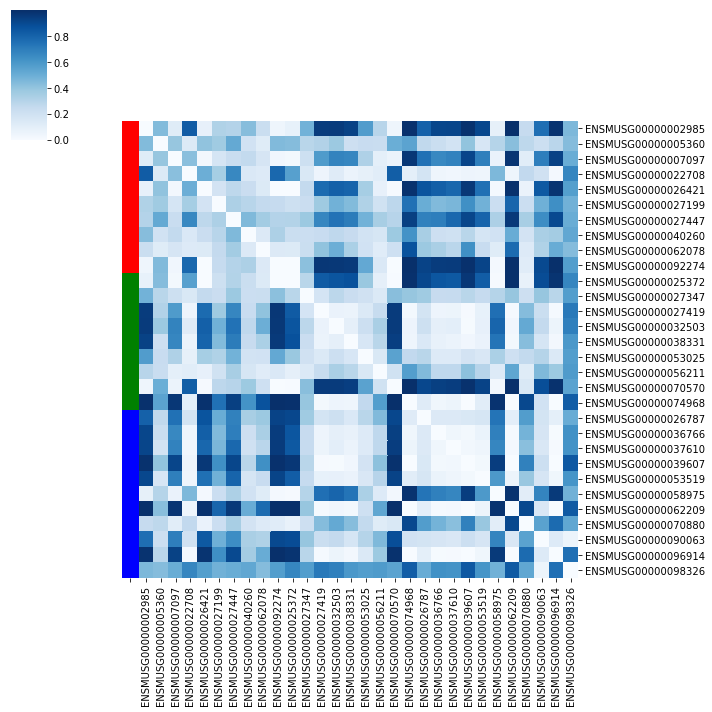

In [423]:
sns.clustermap(df_dist, cmap="Blues", row_colors=row_colors, row_cluster=False, col_cluster=False)

In [381]:
marker_table

cell_type           GABAergic  Glutamatergic  Non-Neuronal
gene_id                                                   
ENSMUSG00000002985        0.0            0.0           1.0
ENSMUSG00000005360        0.0            0.0           1.0
ENSMUSG00000007097        0.0            0.0           1.0
ENSMUSG00000022708        0.0            0.0           1.0
ENSMUSG00000025372        0.0            1.0           0.0
ENSMUSG00000025658        0.0            1.0           0.0
ENSMUSG00000026421        0.0            0.0           1.0
ENSMUSG00000026787        1.0            0.0           0.0
ENSMUSG00000027199        0.0            0.0           1.0
ENSMUSG00000027347        0.0            1.0           0.0
ENSMUSG00000027419        0.0            1.0           0.0
ENSMUSG00000027447        0.0            0.0           1.0
ENSMUSG00000032503        0.0            1.0           0.0
ENSMUSG00000036766        1.0            0.0           0.0
ENSMUSG00000037610        1.0            0.0           0.0
ENSMUSG00000038331        0.0            1.0           0.0
ENSMUSG00000039607        1.0            0.0           0.0
ENSMUSG00000040260        0.0            0.0           1.0
ENSMUSG00000053025        0.0            1.0           0.0
ENSMUSG00000053519        1.0            0.0           0.0
ENSMUSG00000056211        0.0            1.0           0.0
ENSMUSG00000058975        1.0            0.0           0.0
ENSMUSG00000062078        0.0            0.0           1.0
ENSMUSG00000062209        1.0            0.0           0.0
ENSMUSG00000070570        0.0            1.0           0.0
ENSMUSG00000070880        1.0            0.0           0.0
ENSMUSG00000074968        0.0            1.0           0.0
ENSMUSG00000090063        1.0            0.0           0.0
ENSMUSG00000092274        0.0            0.0           1.0
ENSMUSG00000096914        1.0            0.0           0.0
ENSMUSG00000098326        1.0            0.0           0.0
ENSMUSG00000111138        0.0            0.0           1.0

In [377]:
df_2d_jac['AUC'].median()

0.7567251461988304

In [43]:
df_2d_jac['AUC'].median()

0.7131575855725043

In [51]:
df_2d_jac['AUC'].median()

0.7350516750897755

In [53]:
df_2d_jac['AUC'].median()

0.7348074077075757

In [55]:
df_2d_jac['AUC'].median()

0.7378340915461538

In [60]:
df_2d_jac['AUC'].median()

0.7404384844022516

In [64]:
df_2d_jac['AUC'].median()

0.7285538217933243

In [79]:
df_2d_jac['AUC'].mean()

0.7159114082665267

In [342]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value
cell_type                                                           
L2/3 IT     0.560264      2991.583000         0.502776  1.685788e-10
L5 ET       0.690535      2924.999324         0.383366  4.085962e-02
L5 IT       0.583372      2927.524512         0.479471  4.829361e-18
L5/6 NP     0.540500      2958.566910         0.459736  2.019075e-05
L6 CT       0.529078      3001.870454         0.485990  1.307929e-03
L6 IT       0.726044      2503.730135         0.322907  1.509950e-03
L6 IT Car3  0.537332      2968.643607         0.476088  6.316638e-05
L6b         0.527902      2996.323654         0.485808  2.401511e-03
Lamp5       0.578590      2988.501837         0.496596  3.844387e-16
Pvalb       0.642973      2646.949837         0.311784  6.174595e-02
Sncg        0.622575      2813.582685         0.386323  1.417964e-03
Sst         0.787277      2054.616691         0.178319  6.544910e-04
Vip         0.581047      2872.677541         0.431353  5.161788e-17

In [280]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
cell_type                                                          
GABAergic      0.756725        17.896457         0.430622  0.003177
Glutamatergic  0.687831        18.717524         0.582011  0.052311
Non-Neuronal   0.820833        18.033159         0.495000  0.000998

In [808]:
df_2d_jac['AUC'].mean()

0.8417328042328043

(4618, 4618)
(4618, 80)
0.9378545907319186
0.0


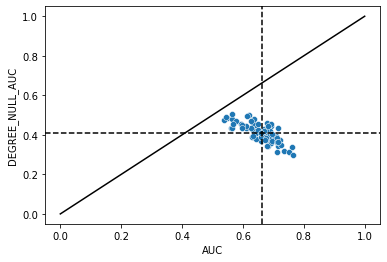

In [1190]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1191]:
df_2d_jac['AUC'].mean()

0.661282315479487

In [538]:
df_optimal_marker

hierarchy_level      marker_set  n_genes        f1
8              class       GABAergic      500  0.997599
20             class   Glutamatergic      200  0.999537
1177        subclass         L2/3 IT      100  0.908418
44     joint_cluster       L2/3 IT_1       50  0.517432
59     joint_cluster       L2/3 IT_2      200  0.548169
...              ...             ...      ...       ...
1110   joint_cluster    Vip Mybpc1_3       20  0.594133
1123   joint_cluster  Vip Serpinf1_1       20  0.414391
1138   joint_cluster  Vip Serpinf1_2      100  0.870805
1150   joint_cluster  Vip Serpinf1_3       50  0.566260
1165   joint_cluster        Vip Sncg      200  0.837217

[101 rows x 4 columns]

In [961]:
df_2d_jac = df_2d_jac.merge(df_optimal_marker, left_on=df_2d_jac.index, right_on='marker_set')

In [346]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value hierarchy_level  \
0   0.560264      2991.583000         0.502776  1.685788e-10        subclass   
1   0.690535      2924.999324         0.383366  4.085962e-02        subclass   
2   0.583372      2927.524512         0.479471  4.829361e-18        subclass   
3   0.540500      2958.566910         0.459736  2.019075e-05        subclass   
4   0.529078      3001.870454         0.485990  1.307929e-03        subclass   
5   0.726044      2503.730135         0.322907  1.509950e-03        subclass   
6   0.537332      2968.643607         0.476088  6.316638e-05        subclass   
7   0.527902      2996.323654         0.485808  2.401511e-03        subclass   
8   0.578590      2988.501837         0.496596  3.844387e-16        subclass   
9   0.642973      2646.949837         0.311784  6.174595e-02        subclass   
10  0.622575      2813.582685         0.386323  1.417964e-03        subclass   
11  0.787277      2054.616691         0.178319  6.544910e-04        subclass   
12  0.581047      2872.677541         0.431353  5.161788e-17        subclass   

    marker_set  n_genes        f1  
0      L2/3 IT     1000  0.726512  
1        L5 ET       10  0.752232  
2        L5 IT     2000  0.753933  
3      L5/6 NP    10000  0.742529  
4        L6 CT     5000  0.565069  
5        L6 IT       20  0.799019  
6   L6 IT Car3     1000  0.736726  
7          L6b     1000  0.772683  
8        Lamp5    10000  0.645717  
9        Pvalb       10  0.000000  
10        Sncg       50  0.765389  
11         Sst       10  0.000000  
12         Vip     5000  0.674320

<AxesSubplot:xlabel='f1', ylabel='AUC'>

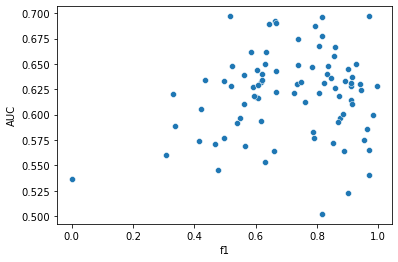

In [962]:
sns.scatterplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

<AxesSubplot:xlabel='f1', ylabel='AUC'>

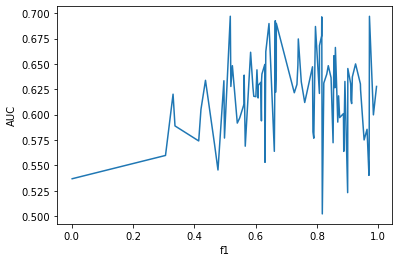

In [505]:
sns.lineplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

<AxesSubplot:xlabel='n_genes', ylabel='AUC'>

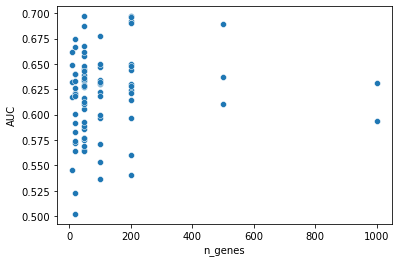

In [501]:
sns.scatterplot(y=df_2d_jac['AUC'], x=df_2d_jac['n_genes'])

(0.0, 201.0)

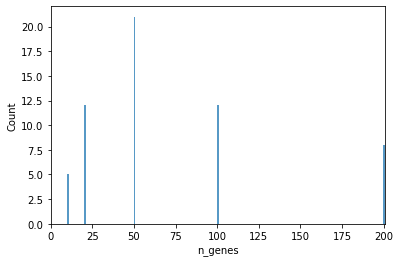

In [162]:
ax = sns.histplot(df_2d_jac['n_genes'], bins=10000)
ax.set_xlim([0,201])

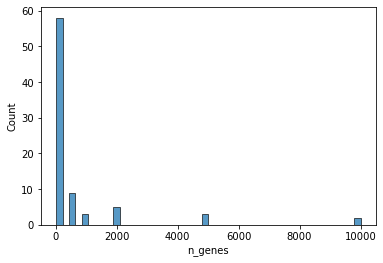

In [159]:
ax = sns.histplot(df_2d_jac['n_genes'],)

In [1180]:
df_2d_jac['n_genes']

0       50
1      200
2     5000
3     5000
4      200
      ... 
75      20
76      20
77     500
78      50
79     500
Name: n_genes, Length: 80, dtype: int64

<AxesSubplot:xlabel='f1', ylabel='AUC'>

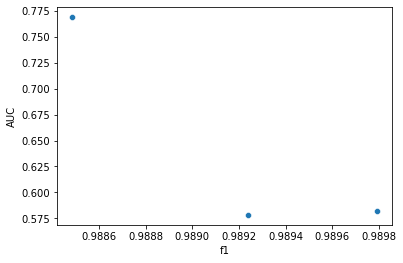

In [784]:
sns.scatterplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

<AxesSubplot:xlabel='f1', ylabel='AUC'>

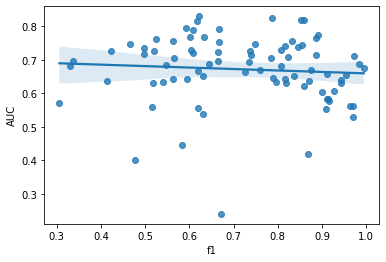

In [524]:
sns.regplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

In [468]:
df_2d_jac['AUC'].mean()

0.671356340110002

In [ ]:
df_optimal_marker

In [370]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
cell_type                                                          
GABAergic      0.756725        17.896457         0.430622  0.003177
Glutamatergic  0.687831        18.717524         0.582011  0.052311
Non-Neuronal   0.820833        18.033159         0.495000  0.000998

In [311]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')


df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmax()]

In [213]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value
cell_type                                                               
L2/3 IT_1       0.733561      3506.493796         0.412596  1.739606e-55
L2/3 IT_2       0.637985      3629.579985         0.439401  2.336410e-20
L2/3 IT_3       0.535113      3733.917255         0.449737  5.855890e-05
L4/5 IT_1       0.641127      3507.638301         0.372313  1.321543e-21
L4/5 IT_2       0.645324      3592.453424         0.420676  1.643804e-22
...                  ...              ...              ...           ...
Vip Mybpc1_3    0.652867      3576.540368         0.406425  7.652021e-25
Vip Serpinf1_1  0.591255      3674.055112         0.427297  7.084149e-10
Vip Serpinf1_2  0.690646      3617.295280         0.413061  3.120479e-37
Vip Serpinf1_3  0.643637      3728.302092         0.450042  3.313931e-22
Vip Sncg        0.663067      3511.266429         0.397031  7.070980e-28

[86 rows x 4 columns]

In [3]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import pandas as pd

In [185]:
SRP_name='aggregates'
resolution='10kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_intra_nanranked.h5'

jac_sim_intra = hm.hiCMatrix(exp_file_path)




all_genes = [x[3].decode() for x in jac_sim_intra.cut_intervals]
df_jac_corr_intra = pd.DataFrame(jac_sim_intra.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [198]:
df_jac_corr = df_jac_corr / df_jac_corr.max().max()

55410.54265398567

In [199]:
df_jac_corr = df_jac_corr / df_jac_corr.max().max()

In [200]:
df_jac_gw = df_jac_corr_intra  + df_jac_corr

In [ ]:
    species_list = ['mouse']
    if species_list == ['human']:
        color_1 = '#98DBF6'
        color_2 = '#00A5E6'
    elif species_list == ['mouse']:
        color_1 = '#F69398'
        color_2 = '#E83B43'
    else:
        color_1 = '#E9DBC4'
        color_2 = '#EC9200'        
    
    res_list = [25]
    #res_list = [10]
    #KR_type_list = ['KR_ranked_KR']
    KR_type_list = ['KR']
    #performance_type_list = ['all']
    edge_type_list = ['contact']
    #performance_type_list = ['inter_only/hic_gene_KR_inter_1_percent_per_chr.csv']
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    
    #f_name = 'hic_gene_corr_inter_1_percent_per_chr.csv'
    #f_name = 'hic_gene_KR_intra_1_percent_per_chr.csv'
    #f_name = 'hic_gene_corr_gw_1_percent_per_chr.csv'

    df_list = []
    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')
        df_seq_depth['species'] = species
        df_list.append(df_seq_depth)

    #whole aggreagte
    import pandas as pd
    empty_list = []

    for species in species_list: 
    #for species in ['human']: 
      #for bin_type in ['gene_bins', 'all_bins', 'non_gene']: 
      for bin_type in ['all_bins']: 
        for resolution in res_list:
            for coef in ['jac_sim']:
            #for coef in ['pcc', 'jac_sim']:
              #for mapping in ['tss']:
              for mapping in ['max']:
                #for percentile in [90]:
                for percentile in [90]:
                    for gene_percentile in [1]:
                    #for gene_percentile in [10]:

                        for KR_type in KR_type_list:
                            for performance_type, agg_type in zip(['/spr/0/all_bins/KR_KR/inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv', '/spr/0/all_bins/KR_KR/inter_only/hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv'], ['spearman']):

                                file_path = f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/aggregates/'

                                file_name = f'{resolution}kbp_raw/{mapping}/{performance_type}'
                                
                                SRP_name = 'aggregates'
                                
                                exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

                                jac_sim = hm.hiCMatrix(exp_file_path)




                                all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
                                #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
                                df_spr_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)



                                try:


                                    df2, delo = run_egad(marker_table, df_spr_corr)
                                    df2['species'] = species
                                    df2['resolution'] = resolution
                                    df2['agg_type'] = agg_type
                                    df2['proj'] = 'all'
                                    df2['edge_type'] = ''
                                    empty_list.append(df2)
                                except:
                                    continue
    df_whole_agg=pd.concat(empty_list)       
    df_whole_agg['counts_inter'] = df_seq_depth['counts_inter'].sum()
    print (df_whole_agg.groupby(['resolution', 'agg_type'])['AUC'].mean())
    
    
    counter = 0
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    for species in species_list: 
        contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
        df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

        import pandas as pd
        empty_list = []

        for proj in df_con['id'].tolist() :
              counter = counter + 1
              

              #for species in ['drosophila', 'drosophila', 'drosophila']: 

              #for bin_type in ['gene_bins', 'all_bins', 'non_gene']: 
              for bin_type in ['all_bins']: 
                for resolution in res_list:
                    for coef in ['jac_sim']:
                    #for coef in ['pcc', 'jac_sim']:
                      #for mapping in ['tss']:
                      for mapping in ['max/spr/0/all_bins/KR_KR']:
                        #print (proj)
                        for percentile in ['90']:
                            for KR_type in KR_type_list:
                                for performance_type in performance_type_list:
                                #for performance_type in ['intra_only', 'inter_only', 'all']:
                                    file_path = f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/{proj}/'
                                    file_name = f'{resolution}kbp_raw/{mapping}/{performance_type}'
                                    
                                    SRP_name = proj
                                
                                    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

                                    jac_sim = hm.hiCMatrix(exp_file_path)




                                    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
                                    #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
                                    df_spr_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)




                                    #file_name = f'{resolution}kbp_raw/{mapping}/{coef}/{percentile}/{bin_type}/{KR_type}/{performance_type}/{f_name}'

                                    try:

                                        df2 = run_egad(marker_table, df_spr_corr)
                                        df2['species'] = species
                                        df2['resolution'] = resolution
                                        df2['proj'] = proj
                                        df2['agg_type'] = 'proj_agg'
                                        #print (proj)
                                        
                                        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                                        df2['counts_inter'] = df_seq_depth_subset['counts_inter'].sum()


                                    except:
                                        #print (f'{file_path}/{file_name}')
                                        print (counter, proj, resolution)
                                        
                                        continue


                                    empty_list.append(df2)
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()

    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_project_network_details.tsv', sep='\t')
        df_seq_depth['species'] = species
        df_seq_depth['project'] = [x.strip() for x in df_seq_depth['project']]
        df_seq_depth['experiment type'] = [x.strip() for x in df_seq_depth['experiment type']]
        #dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]

    import numpy as np
    dt['log_contacts'] = [np.log10(x) for x in dt['counts_inter']]

    dt = dt.merge(df_seq_depth, left_on='proj', right_on='project')
    dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])
    dk['log_contacts'] = [np.log10(x) for x in dk['counts_inter']]

    dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]
    
    #dk = dk[dk['auc'] > 0.5]
    #dk = dk[dk['agg_type']=='proj_agg']
    #print (dk)
    
    
    
    
    import matplotlib.pyplot as plt
    sc_bar = sns.scatterplot(data=dk[dk['resolution']==25], x='log_contacts', y='AUC', style='agg_type', color=color_1,edgecolor="black", s=100, linewidth=1.2, markers =  {"proj_agg": "*", "pearson": "o", "spearman": "^"})
    sc_bar.legend().remove()
    #sc_bar = sns.scatterplot(data=dk[dk['resolution']==100], x='log_contacts', y='auc')
    #dk['log_contacts'] = dk['log_contacts'].round(0)
    #sc_bar = sns.lineplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    
    #sc_bar = sns.regplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    #sc_bar.set(ylim=(0.5, 0.67))
    plt.plot()
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_inter.pdf',
    #        transparent=True)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    #sns.scatterplot(x='resolution', y='auc', data=dt[dt['agg_type']=='all'], ax=ax)
    axb = sns.boxplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='proj_agg'], ax=ax, color=color_1, orient="v")
    #for i, patch in enumerate(axb.artists):
        # Boxes from left to right

     #   patch.set_hatch('//')
    #sns.swarmplot(x='resolution', y='auc', data=dk[dk['agg_type']=='pearson'], ax=ax, size=10, color=color_2, orient="v")
    sns.swarmplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='spearman'], ax=ax, size=10, color="green", orient="v")
    #sns.lineplot(y='resolution', x='auc', data=dt[dt['agg_type']=='all'], ax=ax, color="green")
    #ax.set(ylim=(0.5, 0.67))
    plt.plot()
    
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_all_resol_inter.pdf',
    #        transparent=True)


(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
resolution  agg_type
25          spearman    0.713044
Name: AUC, dtype: float64
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
1 SRP249897 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
2 SRP292639 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
3 SRP217487 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
4 SRP075985 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
5 SRP105082 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
6 SRP110616 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
7 SRP118601 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
8 SRP200567 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
9 SRP223513 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
10 SRP218950 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
11 SRP226118 25


In [74]:
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()


ValueError: No objects to concatenate

In [62]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='10kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['10kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

    jac_sim = hm.hiCMatrix(exp_file_path)




    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))
    
    df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[7])


In [28]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [14]:
df_jac_corr.sum().sum()

57238269.755088426

In [220]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
gitdf = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/ScTypeDB_full_github.tsv', sep='\t')



df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)



gitdf.rename(columns = {'tissueType':'Tissue', 'cellName':'Cell type',
                              'geneSymbolmore1':'Marker genes'}, inplace = True)

df = pd.concat([gitdf, df])
df = df[df['Tissue'].isin(['Brain', 'Adrenal'])]
df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
df = df.drop_duplicates(subset='combined_type')
#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']

for i in tissue_type_list:
    
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    #chrom_for_given_tisse = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list]
    
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    

all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


<ipython-input-220-58d480932ef6>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
<ipython-input-220-58d480932ef6>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [189]:
marker_gene_table

ENSG00000115386  ENSG00000139287  del  \
Immune system-Pro-B cells                   0                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000107447  ENSG00000122852  del  \
Immune system-Pro-B cells                   1                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000054983  del  ENSG00000012048  \
Immune system-Pro-B cells                   0    0                0   
Immune system-Pre-B cells                   0    0                0   
Immune system-Naive B cells                 0    0                0   
Immune system-Memory B cells                0    0                0   
Immune system-Plasma B cells                0    0                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0    0                0   
Teeth-Endothelial cells                     0    0                0   
Teeth-Immune cells                          0    0                0   
Teeth-Glial cells                           0    0                0   
Teeth-Epithelial cells                      0    0                0   

                              ENSG00000078401  ...  ENSG00000183662  \
Immune system-Pro-B cells                   0  ...                0   
Immune system-Pre-B cells                   0  ...                0   
Immune system-Naive B cells                 0  ...                0   
Immune system-Memory B cells                0  ...                0   
Immune system-Plasma B cells                0  ...                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0  ...                0   
Teeth-Endothelial cells                     1  ...                0   
Teeth-Immune cells                          0  ...                0   
Teeth-Glial cells                           0  ...                0   
Teeth-Epithelial cells                      0  ...                0   

                              ENSG00000172936  ENSG00000166573  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells      

In [83]:
set(gitdf) - set (df)

{'Adrenal', 'Intestine', 'Placenta', 'Spleen', 'Stomach', 'Thymus'}

In [84]:
set(df) - set (gitdf)

{'Embryo',
 'Gastrointestinal tract',
 'Ovary',
 'Skin',
 'Teeth',
 'Testis',
 'White adipose tissue'}

In [183]:
marker_gene_table

ENSG00000115386  ENSG00000139287  del  \
Immune system-Pro-B cells                   0                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000107447  ENSG00000122852  del  \
Immune system-Pro-B cells                   1                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000054983  del  ENSG00000012048  \
Immune system-Pro-B cells                   0    0                0   
Immune system-Pre-B cells                   0    0                0   
Immune system-Naive B cells                 0    0                0   
Immune system-Memory B cells                0    0                0   
Immune system-Plasma B cells                0    0                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0    0                0   
Teeth-Endothelial cells                     0    0                0   
Teeth-Immune cells                          0    0                0   
Teeth-Glial cells                           0    0                0   
Teeth-Epithelial cells                      0    0                0   

                              ENSG00000078401  ...  ENSG00000183662  \
Immune system-Pro-B cells                   0  ...                0   
Immune system-Pre-B cells                   0  ...                0   
Immune system-Naive B cells                 0  ...                0   
Immune system-Memory B cells                0  ...                0   
Immune system-Plasma B cells                0  ...                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0  ...                0   
Teeth-Endothelial cells                     1  ...                0   
Teeth-Immune cells                          0  ...                0   
Teeth-Glial cells                           0  ...                0   
Teeth-Epithelial cells                      0  ...                0   

                              ENSG00000172936  ENSG00000166573  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells      

In [158]:
df_TF = gitdf[gitdf['species'] != 'Mm']
df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['official gene symbol'] ]



df_TF = df_TF[df_TF['ensg_gene'] != 'del']



df_TF['counter'] = 1

df_TF_egad = df_TF.pivot_table(index=["ensg_gene"], columns='germ layer', values='counter',  aggfunc='max').T
marker_gene_table = df_TF_egad.fillna(0)


<ipython-input-158-47fc4ea4522e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['official gene symbol'] ]


In [208]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/PanglaoDB_markers_27_Mar_2020.tsv', sep='\t')
df[df['species'] != 'Mm']

df = df[df['tissueType'].isin(['Brain'])]
df['combined_type'] = df['organ'] + '-' + df['cell type']

#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['official gene symbol'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['official gene symbol'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


KeyError: 'tissueType'

In [102]:
df = marker_gene_table.sum().reset_index()

In [103]:
marker_gene_table = marker_gene_table.drop(df[df[0]>1]['index'].tolist(), axis = 1)

<AxesSubplot:ylabel='Count'>

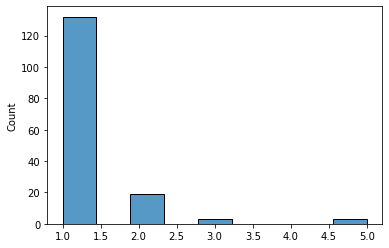

In [51]:
sns.histplot(marker_gene_table.sum())

(261, 261)
(261, 36)
0.9680715197956578
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


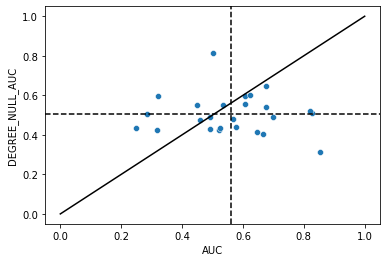

In [221]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_gw)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [222]:
df_2d_jac['AUC'].mean()

0.5595002913340569

In [223]:
df_2d_jac.sort_values(by=['AUC']).tail(30)

AUC  AVG_NODE_DEGREE  \
Adrenal-Sympathoblasts                 0.249016       270.226390   
Brain-Oligodendrocytes                 0.284360       272.859779   
Brain-Neural Progenitor cells          0.318399       265.750945   
Brain-Schwann precursor cells          0.320261       290.486189   
Adrenal-SLC26A4_PAEP positive cells    0.447707       283.895108   
Brain-Mature neurons                   0.458630       276.327911   
Brain-GABAergic neurons                0.490196       257.173171   
Brain-Microglial cells                 0.491468       269.383493   
Brain-Immune system cells              0.500000       308.930444   
Adrenal-Schwann cells                  0.521400       264.949191   
Adrenal-Lymphoid cells                 0.524682       260.901189   
Brain-Cancer stem cells                0.535784       282.416899   
Brain-Glutamatergic neurons            0.566710       269.699737   
Adrenal-Megakaryocytes                 0.577867       259.799391   
Brain-Astrocytes                       0.606127       283.187385   
Adrenal-Erythroblasts                  0.607067       282.010021   
Adrenal-Vascular endothelial cells     0.622621       288.407145   
Brain-Radial glial cells               0.646756       259.686479   
Adrenal-Stromal cells                  0.665788       265.989080   
Adrenal-Myeloid cells                  0.675911       270.970484   
Brain-Endothelial cells                0.676420       295.325936   
Brain-Dopaminergic neurons             0.697619       272.029501   
Adrenal-CSH1_CSH2 positive cells       0.820580       287.118315   
Brain-Neuroepithelial cells            0.828327       279.264191   
Brain-Oligodendrocyte precursor cells  0.853813       237.095503   

                                       DEGREE_NULL_AUC   P_Value  
Adrenal-Sympathoblasts                        0.433071  0.018456  
Brain-Oligodendrocytes                        0.506693  0.008096  
Brain-Neural Progenitor cells                 0.425680  0.008982  
Brain-Schwann precursor cells                 0.598693  0.101839  
Adrenal-SLC26A4_PAEP positive cells           0.552028  0.129433  
Brain-Mature neurons                          0.477273  0.371641  
Brain-GABAergic neurons                       0.430719  0.178585  
Brain-Microglial cells                        0.489198  0.330668  
Brain-Immune system cells                     0.813072  0.415369  
Adrenal-Schwann cells                         0.424812  0.396232  
Adrenal-Lymphoid cells                        0.435794  0.267279  
Brain-Cancer stem cells                       0.552941  0.409272  
Brain-Glutamatergic neurons                   0.479753  0.171519  
Adrenal-Megakaryocytes                        0.441455  0.042519  
Brain-Astrocytes                              0.554201  0.071724  
Adrenal-Erythroblasts                         0.598182  0.002765  
Adrenal-Vascular endothelial cells            0.602789  0.090246  
Brain-Radial glial cells                      0.413818  0.045605  
Adrenal-Stromal cells                         0.406621  0.047102  
Adrenal-Myeloid cells                         0.542545  0.034683  
Brain-Endothelial cells                       0.648929  0.018947  
Brain-Dopaminergic neurons                    0.490741  0.055307  
Adrenal-CSH1_CSH2 positive cells              0.519375  0.000020  
Brain-Neuroepithelial cells                   0.512846  0.004822  
Brain-Oligodendrocyte precursor cells         0.315686  0.002726

(2430, 2430)
(2430, 324)
0.9943377533912513
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


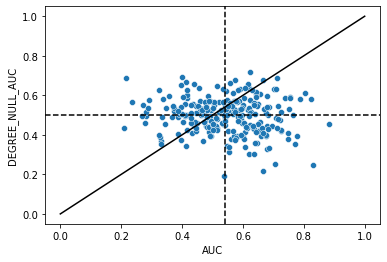

In [190]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr_intra)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [192]:
df_2d_jac.sort_values(by=['AUC']).tail(10)

AUC  AVG_NODE_DEGREE  \
Immune system-Neutrophils                      0.753567      1233.089870   
Placenta-IGFBP1_DKK1 positive cells            0.753950      1234.348106   
Gastrointestinal tract-Enterochromaffin cells  0.764910      1222.946982   
Immune system-Macrophages                      0.770894      1200.991514   
Intestine-Lymphoid cells                       0.778593      1208.634666   
Intestine-Erythroblasts                        0.786054      1221.515029   
Stomach-Myeloid cells                          0.804727      1234.866358   
Adrenal-Myeloid cells                          0.823953      1217.882820   
White adipose tissue-Mesothelial cells         0.830409      1190.292587   
Adrenal-CSH1_CSH2 positive cells               0.883454      1213.186840   

                                               DEGREE_NULL_AUC   P_Value  
Immune system-Neutrophils                             0.589350  0.000156  
Placenta-IGFBP1_DKK1 positive cells                   0.585967  0.002217  
Gastrointestinal tract-Enterochromaffin cells         0.500083  0.001795  
Immune system-Macrophages                             0.353940  0.012746  
Intestine-Lymphoid cells                              0.394096  0.004614  
Intestine-Erythroblasts                               0.583254  0.000067  
Stomach-Myeloid cells                                 0.610987  0.000033  
Adrenal-Myeloid cells                                 0.583111  0.001632  
White adipose tissue-Mesothelial cells                0.246800  0.000921  
Adrenal-CSH1_CSH2 positive cells                      0.455121  0.000007

(2430, 2430)
(2430, 324)
0.9943377533912513
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


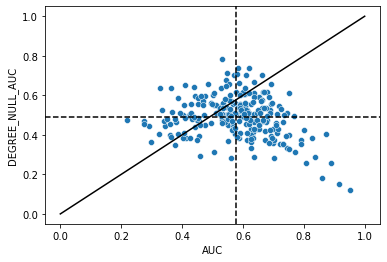

In [179]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [184]:
df_2d_jac.sort_values(by=['AUC']).tail(10)

AUC  AVG_NODE_DEGREE  \
White adipose tissue-Adipocytes                   0.791810     6.942758e+07   
Brain-Neuroepithelial cells                       0.799741     7.563654e+07   
White adipose tissue-Smooth Muscle cells          0.807774     6.047817e+07   
Adrenal-Stromal cells                             0.825580     7.282575e+07   
White adipose tissue-Lymphatic Endothelial cells  0.836379     6.743732e+07   
White adipose tissue-Mesothelial cells            0.860274     6.058658e+07   
Immune system-Eosinophils                         0.874426     7.586037e+07   
White adipose tissue-Endothelial cells            0.890739     6.223762e+07   
White adipose tissue-Pericytes                    0.916563     5.733133e+07   
White adipose tissue-Endometrium                  0.951831     5.453354e+07   

                                                  DEGREE_NULL_AUC  \
White adipose tissue-Adipocytes                          0.353414   
Brain-Neuroepithelial cells                              0.423101   
White adipose tissue-Smooth Muscle cells                 0.256930   
Adrenal-Stromal cells                                    0.381606   
White adipose tissue-Lymphatic Endothelial cells         0.286530   
White adipose tissue-Mesothelial cells                   0.183165   
Immune system-Eosinophils                                0.406281   
White adipose tissue-Endothelial cells                   0.258882   
White adipose tissue-Pericytes                           0.152433   
White adipose tissue-Endometrium                         0.123380   

                                                       P_Value  
White adipose tissue-Adipocytes                   1.003347e-03  
Brain-Neuroepithelial cells                       5.484859e-03  
White adipose tissue-Smooth Muscle cells          5.326387e-04  
Adrenal-Stromal cells                             2.510403e-03  
White adipose tissue-Lymphatic Endothelial cells  2.986060e-07  
White adipose tissue-Mesothelial cells            2.220305e-04  
Immune system-Eosinophils                         1.556932e-04  
White adipose tissue-Endothelial cells            6.014601e-07  
White adipose tissue-Pericytes                    4.161103e-07  
White adipose tissue-Endometrium                  5.749189e-08

(2118, 2118)
(2118, 324)
0.9941666958113291
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


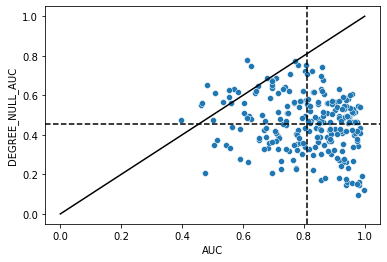

In [174]:
df_2d_exp, go_chrom  = run_egad(marker_gene_table.T, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_exp, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_exp['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_exp['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [175]:
df_2d_jac.reset_index(inplace=True)
df_2d_exp.reset_index(inplace=True)
coexp_contact = df_2d_jac.merge(df_2d_exp, left_on='index', right_on='index')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_y', ylabel='AUC_x'>

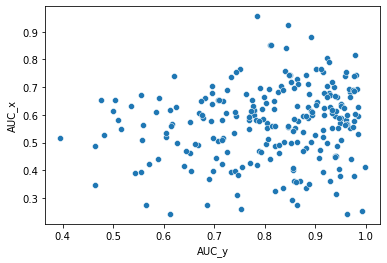

In [176]:
sns.scatterplot(coexp_contact['AUC_y'], coexp_contact['AUC_x'])

In [168]:
df_2d_exp.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Immune system-Basophils                    0.966514       686.331847   
Immune system-Naive CD8+ T cells           0.968314       821.950864   
Immune system-γδ-T cells                   0.968605       769.553020   
Immune system--T cells                     0.968899       769.553020   
Placenta-Lymphoid cells                    0.969792       713.832540   
Placenta-Myeloid cells                     0.973610       674.424280   
Stomach-Lymphoid cells                     0.974136       777.257123   
Placenta-Megakaryocytes                    0.975818       715.116747   
Stomach-Squamous epithelial cells          0.975893       421.026389   
Heart-Lymphoid cells                       0.976310       680.726533   
Immune system-Mast cells                   0.976431       838.248697   
Intestine-Chromaffin cells                 0.978456       351.112587   
Immune system-Eosinophils                  0.978604       644.942277   
Adrenal-Erythroblasts                      0.980016       422.470634   
Placenta-AFP_ALB positive cells            0.982184       433.979287   
Adrenal-Lymphoid cells                     0.983204       745.482143   
Immune system-ISG expressing immune cells  0.984182       845.937118   
Intestine-Lymphoid cells                   0.984755       729.664059   
Muscle-Erythroblasts                       0.992657       456.658236   
Intestine-Erythroblasts                    0.997374       395.921133   

                                           DEGREE_NULL_AUC       P_Value  
Immune system-Basophils                           0.396859  8.957349e-08  
Immune system-Naive CD8+ T cells                  0.515133  4.288808e-10  
Immune system-γδ-T cells                          0.464349  8.119871e-11  
Immune system--T cells                            0.464349  5.924728e-11  
Placenta-Lymphoid cells                           0.411246  2.444644e-08  
Placenta-Myeloid cells                            0.380619  8.182613e-09  
Stomach-Lymphoid cells                            0.467312  2.445967e-09  
Placenta-Megakaryocytes                           0.416996  4.939503e-07  
Stomach-Squamous epithelial cells                 0.149151  1.253213e-05  
Heart-Lymphoid cells                              0.368074  4.947886e-10  
Immune system-Mast cells                          0.545533  3.501668e-05  
Intestine-Chromaffin cells                        0.098011  3.959878e-05  
Immune system-Eosinophils                         0.343304  5.867062e-04  
Adrenal-Erythroblasts                             0.146979  2.215531e-06  
Placenta-AFP_ALB positive cells                   0.163472  1.149528e-07  
Adrenal-Lymphoid cells                            0.433682  4.165141e-09  
Immune system-ISG expressing immune cells         0.540646  3.247684e-07  
Intestine-Lymphoid cells                          0.410782  1.164714e-06  
Muscle-Erythroblasts                              0.193468  8.335917e-09  
Intestine-Erythroblasts                           0.122622  7.362984e-09

In [169]:
df_2d_jac.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Adrenal-Erythroblasts                             0.744015     7.830639e+07   
Eye-GABAergic amacrine cells                      0.745241     7.268417e+07   
Stomach-PDE1C_ACSM3 positive cells                0.754132     7.301663e+07   
Heart-Megakaryocytes                              0.754374     7.470928e+07   
Immune system-Intermediate monocytes              0.755359     8.918103e+07   
Adrenal-SLC26A4_PAEP positive cells               0.757836     8.059366e+07   
Eye-Glycinergic amacrine cells                    0.758436     7.143455e+07   
Immune system-Non-classical monocytes             0.765285     7.983960e+07   
Adrenal-Stromal cells                             0.766023     7.476892e+07   
Spleen-Stromal cells                              0.767047     6.456358e+07   
White adipose tissue-Adipocytes                   0.789524     7.134295e+07   
Adrenal-CSH1_CSH2 positive cells                  0.800541     8.125798e+07   
Brain-Neuroepithelial cells                       0.805471     7.778916e+07   
Immune system-Eosinophils                         0.817843     7.799499e+07   
White adipose tissue-Mesothelial cells            0.842210     6.219281e+07   
White adipose tissue-Lymphatic Endothelial cells  0.851003     6.926410e+07   
White adipose tissue-Endothelial cells            0.853651     6.394237e+07   
White adipose tissue-Adipose progenitor cells     0.879674     6.533446e+07   
White adipose tissue-Pericytes                    0.924143     5.884099e+07   
White adipose tissue-Endometrium                  0.955802     5.597243e+07   

                                                  DEGREE_NULL_AUC  \
Adrenal-Erythroblasts                                    0.472669   
Eye-GABAergic amacrine cells                             0.350712   
Stomach-PDE1C_ACSM3 positive cells                       0.374127   
Heart-Megakaryocytes                                     0.413942   
Immune system-Intermediate monocytes                     0.611174   
Adrenal-SLC26A4_PAEP positive cells                      0.496535   
Eye-Glycinergic amacrine cells                           0.331923   
Immune system-Non-classical monocytes                    0.509710   
Adrenal-Stromal cells                                    0.379877   
Spleen-Stromal cells                                     0.327521   
White adipose tissue-Adipocytes                          0.352323   
Adrenal-CSH1_CSH2 positive cells                         0.406855   
Brain-Neuroepithelial cells                              0.421812   
Immune system-Eosinophils                                0.404308   
White adipose tissue-Mesothelial cells                   0.181567   
White adipose tissue-Lymphatic Endothelial cells         0.284352   
White adipose tissue-Endothelial cells                   0.258357   
White adipose tissue-Adipose progenitor cells            0.314332   
White adipose tissue-Pericytes                           0.151323   
White adipose tissue-Endometrium                         0.122448   

                                                       P_Value  
Adrenal-Erythroblasts                             1.577830e-02  
Eye-GABAergic amacrine cells                      1.214904e-02  
Stomach-PDE1C_ACSM3 positive cells                1.073852e-03  
Heart-Megakaryocytes                              1.688054e-03  
Immune system-Intermediate monocytes              2.788973e-03  
Adrenal-SLC26A4_PAEP positive cells               1.268912e-02  
Eye-Glycinergic amacrine cells                    6.499352e-03  
Immune system-Non-classical monocytes             2.098806e-04  
Adrenal-Stromal cells                             5.048967e-03  
Spleen-Stromal cells                              3.439434e-03  
White adipose tissue-Adipocytes                   1.522735e-03  
Adrenal-CSH1_CSH2 positive cells                  8.298341e-05  
Brain-Neuroepithelial cells                       2.012711e-03  
Immune system-Eosinophils          

In [215]:
y = marker_gene_table.T

genes_intersect = y.index.intersection(df_jac_corr.index)

nw = df_jac_corr.loc[genes_intersect, genes_intersect]

marker_gene_table = marker_gene_table.loc[:, genes_intersect]

species= marker_gene_table.T.idxmax(axis=1)

lut = dict(zip(species.unique(), sns.color_palette("hls", 20)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
#lut = dict(zip(species.unique(), "rrbb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)
g = sns.clustermap(nw, row_colors=row_colors, row_cluster=True, metric="correlation")
